##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Training and evaluation with the built-in methods

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/keras/train_and_evaluate"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/snapshot-keras/site/en/guide/keras/train_and_evaluate.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/keras-team/keras-io/blob/master/guides/training_with_built_in_methods.py"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/keras/train_and_evaluate.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Introduction

This guide covers training, evaluation, and prediction (inference) models
when using built-in APIs for training & validation (such as `model.fit()`,
`model.evaluate()`, `model.predict()`).

If you are interested in leveraging `fit()` while specifying your
own training step function, see the guide
["customizing what happens in `fit()`"](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/).

If you are interested in writing your own training & evaluation loops from
scratch, see the guide
["writing a training loop from scratch"](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/).

In general, whether you are using built-in loops or writing your own, model training &
evaluation works strictly in the same way across every kind of Keras model --
Sequential models, models built with the Functional API, and models written from
scratch via model subclassing.

This guide doesn't cover distributed training. For distributed training, see
our [guide to multi-gpu & distributed training](/guides/distributed_training/).

## API overview: a first end-to-end example

When passing data to the built-in training loops of a model, you should either use
**NumPy arrays** (if your data is small and fits in memory) or **`tf.data Dataset`
objects**. In the next few paragraphs, we'll use the MNIST dataset as NumPy arrays, in
order to demonstrate how to use optimizers, losses, and metrics.

Let's consider the following model (here, we build in with the Functional API, but it
could be a Sequential model or a subclassed model as well):

In [3]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Here's what the typical end-to-end workflow looks like, consisting of:

- Training
- Validation on a holdout set generated from the original training data
- Evaluation on the test data

We'll use MNIST data for this example.

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

We specify the training configuration (optimizer, loss, metrics):

In [5]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

We call `fit()`, which will train the model by slicing the data into "batches" of size
"batch_size", and repeatedly iterating over the entire dataset for a given number of
"epochs".

In [6]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data


Epoch 1/2


  1/782 [..............................] - ETA: 11:02 - loss: 2.3595 - sparse_categorical_accuracy: 0.0469

 22/782 [..............................] - ETA: 1s - loss: 1.9683 - sparse_categorical_accuracy: 0.3737   

 44/782 [>.............................] - ETA: 1s - loss: 1.7000 - sparse_categorical_accuracy: 0.4904

 66/782 [=>............................] - ETA: 1s - loss: 1.5138 - sparse_categorical_accuracy: 0.5571

 88/782 [==>...........................] - ETA: 1s - loss: 1.3783 - sparse_categorical_accuracy: 0.6019

111/782 [===>..........................] - ETA: 1s - loss: 1.2709 - sparse_categorical_accuracy: 0.6358

134/782 [====>.........................] - ETA: 1s - loss: 1.1862 - sparse_categorical_accuracy: 0.6621

157/782 [=====>........................] - ETA: 1s - loss: 1.1173 - sparse_categorical_accuracy: 0.6830

181/782 [=====>........................] - ETA: 1s - loss: 1.0574 - sparse_categorical_accuracy: 0.7008

203/782 [======>.......................] - ETA: 1s - loss: 1.0106 - sparse_categorical_accuracy: 0.7145

223/782 [=======>......................] - ETA: 1s - loss: 0.9734 - sparse_categorical_accuracy: 0.7254

246/782 [========>.....................] - ETA: 1s - loss: 0.9358 - sparse_categorical_accuracy: 0.7363

269/782 [=========>....................] - ETA: 1s - loss: 0.9025 - sparse_categorical_accuracy: 0.7458

291/782 [==========>...................] - ETA: 1s - loss: 0.8741 - sparse_categorical_accuracy: 0.7539

313/782 [===========>..................] - ETA: 1s - loss: 0.8483 - sparse_categorical_accuracy: 0.7612

335/782 [===========>..................] - ETA: 1s - loss: 0.8250 - sparse_categorical_accuracy: 0.7678

358/782 [============>.................] - ETA: 0s - loss: 0.8027 - sparse_categorical_accuracy: 0.7741

381/782 [=============>................] - ETA: 0s - loss: 0.7823 - sparse_categorical_accuracy: 0.7799

402/782 [==============>...............] - ETA: 0s - loss: 0.7652 - sparse_categorical_accuracy: 0.7848

425/782 [===============>..............] - ETA: 0s - loss: 0.7479 - sparse_categorical_accuracy: 0.7897

448/782 [================>.............] - ETA: 0s - loss: 0.7319 - sparse_categorical_accuracy: 0.7942

471/782 [=================>............] - ETA: 0s - loss: 0.7170 - sparse_categorical_accuracy: 0.7984

493/782 [=================>............] - ETA: 0s - loss: 0.7037 - sparse_categorical_accuracy: 0.8021

517/782 [==================>...........] - ETA: 0s - loss: 0.6901 - sparse_categorical_accuracy: 0.8059

540/782 [===================>..........] - ETA: 0s - loss: 0.6779 - sparse_categorical_accuracy: 0.8093

562/782 [====================>.........] - ETA: 0s - loss: 0.6668 - sparse_categorical_accuracy: 0.8124

584/782 [=====================>........] - ETA: 0s - loss: 0.6564 - sparse_categorical_accuracy: 0.8153

607/782 [======================>.......] - ETA: 0s - loss: 0.6461 - sparse_categorical_accuracy: 0.8182

630/782 [=======================>......] - ETA: 0s - loss: 0.6363 - sparse_categorical_accuracy: 0.8210

652/782 [========================>.....] - ETA: 0s - loss: 0.6274 - sparse_categorical_accuracy: 0.8234

673/782 [========================>.....] - ETA: 0s - loss: 0.6193 - sparse_categorical_accuracy: 0.8257

695/782 [=========================>....] - ETA: 0s - loss: 0.6113 - sparse_categorical_accuracy: 0.8280

717/782 [==========================>...] - ETA: 0s - loss: 0.6035 - sparse_categorical_accuracy: 0.8301

741/782 [===========================>..] - ETA: 0s - loss: 0.5954 - sparse_categorical_accuracy: 0.8324

763/782 [============================>.] - ETA: 0s - loss: 0.5883 - sparse_categorical_accuracy: 0.8343

782/782 [==============================] - 3s 3ms/step - loss: 0.5821 - sparse_categorical_accuracy: 0.8361 - val_loss: 0.1893 - val_sparse_categorical_accuracy: 0.9483


Epoch 2/2
  1/782 [..............................] - ETA: 1s - loss: 0.2613 - sparse_categorical_accuracy: 0.8906

 23/782 [..............................] - ETA: 1s - loss: 0.1810 - sparse_categorical_accuracy: 0.9395

 46/782 [>.............................] - ETA: 1s - loss: 0.1814 - sparse_categorical_accuracy: 0.9424

 70/782 [=>............................] - ETA: 1s - loss: 0.1800 - sparse_categorical_accuracy: 0.9439

 92/782 [==>...........................] - ETA: 1s - loss: 0.1795 - sparse_categorical_accuracy: 0.9448

115/782 [===>..........................] - ETA: 1s - loss: 0.1789 - sparse_categorical_accuracy: 0.9454

139/782 [====>.........................] - ETA: 1s - loss: 0.1780 - sparse_categorical_accuracy: 0.9460

162/782 [=====>........................] - ETA: 1s - loss: 0.1770 - sparse_categorical_accuracy: 0.9465

183/782 [======>.......................] - ETA: 1s - loss: 0.1763 - sparse_categorical_accuracy: 0.9468

206/782 [======>.......................] - ETA: 1s - loss: 0.1761 - sparse_categorical_accuracy: 0.9470

229/782 [=======>......................] - ETA: 1s - loss: 0.1758 - sparse_categorical_accuracy: 0.9472

252/782 [========>.....................] - ETA: 1s - loss: 0.1755 - sparse_categorical_accuracy: 0.9473

274/782 [=========>....................] - ETA: 1s - loss: 0.1751 - sparse_categorical_accuracy: 0.9475

296/782 [==========>...................] - ETA: 1s - loss: 0.1745 - sparse_categorical_accuracy: 0.9477

319/782 [===========>..................] - ETA: 1s - loss: 0.1738 - sparse_categorical_accuracy: 0.9479

342/782 [============>.................] - ETA: 0s - loss: 0.1732 - sparse_categorical_accuracy: 0.9481

364/782 [============>.................] - ETA: 0s - loss: 0.1727 - sparse_categorical_accuracy: 0.9483

387/782 [=============>................] - ETA: 0s - loss: 0.1722 - sparse_categorical_accuracy: 0.9485

411/782 [==============>...............] - ETA: 0s - loss: 0.1719 - sparse_categorical_accuracy: 0.9486

435/782 [===============>..............] - ETA: 0s - loss: 0.1715 - sparse_categorical_accuracy: 0.9487

458/782 [================>.............] - ETA: 0s - loss: 0.1712 - sparse_categorical_accuracy: 0.9489

481/782 [=================>............] - ETA: 0s - loss: 0.1710 - sparse_categorical_accuracy: 0.9490

504/782 [==================>...........] - ETA: 0s - loss: 0.1707 - sparse_categorical_accuracy: 0.9491

526/782 [===================>..........] - ETA: 0s - loss: 0.1704 - sparse_categorical_accuracy: 0.9491

549/782 [====================>.........] - ETA: 0s - loss: 0.1702 - sparse_categorical_accuracy: 0.9492

572/782 [====================>.........] - ETA: 0s - loss: 0.1699 - sparse_categorical_accuracy: 0.9493

595/782 [=====================>........] - ETA: 0s - loss: 0.1697 - sparse_categorical_accuracy: 0.9494

618/782 [======================>.......] - ETA: 0s - loss: 0.1694 - sparse_categorical_accuracy: 0.9495

640/782 [=======================>......] - ETA: 0s - loss: 0.1692 - sparse_categorical_accuracy: 0.9496

662/782 [========================>.....] - ETA: 0s - loss: 0.1689 - sparse_categorical_accuracy: 0.9496

685/782 [=========================>....] - ETA: 0s - loss: 0.1687 - sparse_categorical_accuracy: 0.9497

709/782 [==========================>...] - ETA: 0s - loss: 0.1684 - sparse_categorical_accuracy: 0.9498

732/782 [===========================>..] - ETA: 0s - loss: 0.1682 - sparse_categorical_accuracy: 0.9499

753/782 [===========================>..] - ETA: 0s - loss: 0.1680 - sparse_categorical_accuracy: 0.9499

776/782 [============================>.] - ETA: 0s - loss: 0.1677 - sparse_categorical_accuracy: 0.9500

782/782 [==============================] - 2s 3ms/step - loss: 0.1676 - sparse_categorical_accuracy: 0.9500 - val_loss: 0.1631 - val_sparse_categorical_accuracy: 0.9488


The returned "history" object holds a record of the loss values and metric values
during training:

In [7]:
history.history

{'loss': [0.344687819480896, 0.15941613912582397],
 'sparse_categorical_accuracy': [0.9019200205802917, 0.9523000121116638],
 'val_loss': [0.1892719268798828, 0.1630939543247223],
 'val_sparse_categorical_accuracy': [0.9483000040054321, 0.9488000273704529]}

We evaluate the model on the test data via `evaluate()`:

In [8]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
 1/79 [..............................] - ETA: 1s - loss: 0.0696 - sparse_categorical_accuracy: 0.9844

30/79 [==========>...................] - ETA: 0s - loss: 0.2287 - sparse_categorical_accuracy: 0.9284

59/79 [=====================>........] - ETA: 0s - loss: 0.1909 - sparse_categorical_accuracy: 0.9415

79/79 [==============================] - 0s 2ms/step - loss: 0.1750 - sparse_categorical_accuracy: 0.9460


test loss, test acc: [0.17500483989715576, 0.9459999799728394]
Generate predictions for 3 samples
predictions shape: (3, 10)


Now, let's review each piece of this workflow in detail.

## The `compile()` method: specifying a loss, metrics, and an optimizer

To train a model with `fit()`, you need to specify a loss function, an optimizer, and
optionally, some metrics to monitor.

You pass these to the model as arguments to the `compile()` method:

In [9]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

The `metrics` argument should be a list -- your model can have any number of metrics.

If your model has multiple outputs, you can specify different losses and metrics for
each output, and you can modulate the contribution of each output to the total loss of
the model. You will find more details about this in the section **"Passing data to
multi-input, multi-output models"**.

Note that if you're satisfied with the default settings, in many cases the optimizer,
loss, and metrics can be specified via string identifiers as a shortcut:

In [10]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

For later reuse, let's put our model definition and compile step in functions; we will
call them several times across different examples in this guide.

In [11]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model


### Many built-in optimizers, losses, and metrics are available

In general, you won't have to create from scratch your own losses, metrics, or
optimizers, because what you need is likely already part of the Keras API:

Optimizers:

- `SGD()` (with or without momentum)
- `RMSprop()`
- `Adam()`
- etc.

Losses:

- `MeanSquaredError()`
- `KLDivergence()`
- `CosineSimilarity()`
- etc.

Metrics:

- `AUC()`
- `Precision()`
- `Recall()`
- etc.

### Custom losses

There are two ways to provide custom losses with Keras. The first example creates a
function that accepts inputs `y_true` and `y_pred`. The following example shows a loss
function that computes the mean squared error between the real data and the
predictions:

In [12]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 3:40 - loss: 0.0897

 30/782 [>.............................] - ETA: 1s - loss: 0.0816  

 60/782 [=>............................] - ETA: 1s - loss: 0.0707

 89/782 [==>...........................] - ETA: 1s - loss: 0.0628

118/782 [===>..........................] - ETA: 1s - loss: 0.0569

149/782 [====>.........................] - ETA: 1s - loss: 0.0521

180/782 [=====>........................] - ETA: 1s - loss: 0.0484

212/782 [=======>......................] - ETA: 0s - loss: 0.0454

244/782 [========>.....................] - ETA: 0s - loss: 0.0429

274/782 [=========>....................] - ETA: 0s - loss: 0.0409

303/782 [==========>...................] - ETA: 0s - loss: 0.0393

335/782 [===========>..................] - ETA: 0s - loss: 0.0377

365/782 [=============>................] - ETA: 0s - loss: 0.0363

396/782 [==============>...............] - ETA: 0s - loss: 0.0351

427/782 [===============>..............] - ETA: 0s - loss: 0.0340

459/782 [================>.............] - ETA: 0s - loss: 0.0330

491/782 [=================>............] - ETA: 0s - loss: 0.0321

522/782 [===================>..........] - ETA: 0s - loss: 0.0313

554/782 [====================>.........] - ETA: 0s - loss: 0.0306

585/782 [=====================>........] - ETA: 0s - loss: 0.0299

617/782 [======================>.......] - ETA: 0s - loss: 0.0292

648/782 [=======================>......] - ETA: 0s - loss: 0.0286

679/782 [=========================>....] - ETA: 0s - loss: 0.0281

711/782 [==========================>...] - ETA: 0s - loss: 0.0275

741/782 [===========================>..] - ETA: 0s - loss: 0.0271

771/782 [============================>.] - ETA: 0s - loss: 0.0266

782/782 [==============================] - 2s 2ms/step - loss: 0.0265


If you need a loss function that takes in parameters beside `y_true` and `y_pred`, you
can subclass the `tf.keras.losses.Loss` class and implement the following two methods:

- `__init__(self)`: accept parameters to pass during the call of your loss function
- `call(self, y_true, y_pred)`: use the targets (y_true) and the model predictions
(y_pred) to compute the model's loss

Let's say you want to use mean squared error, but with an added term that
will de-incentivize  prediction values far from 0.5 (we assume that the categorical
targets are one-hot encoded and take values between 0 and 1). This
creates an incentive for the model not to be too confident, which may help
reduce overfitting (we won't know if it works until we try!).

Here's how you would do it:

In [13]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 4:24 - loss: 0.1061

 26/782 [..............................] - ETA: 1s - loss: 0.1001  

 52/782 [>.............................] - ETA: 1s - loss: 0.0917

 78/782 [=>............................] - ETA: 1s - loss: 0.0846

106/782 [===>..........................] - ETA: 1s - loss: 0.0787

133/782 [====>.........................] - ETA: 1s - loss: 0.0743

160/782 [=====>........................] - ETA: 1s - loss: 0.0709

187/782 [======>.......................] - ETA: 1s - loss: 0.0681

214/782 [=======>......................] - ETA: 1s - loss: 0.0658

240/782 [========>.....................] - ETA: 1s - loss: 0.0639

267/782 [=========>....................] - ETA: 0s - loss: 0.0622

293/782 [==========>...................] - ETA: 0s - loss: 0.0608

319/782 [===========>..................] - ETA: 0s - loss: 0.0595

345/782 [============>.................] - ETA: 0s - loss: 0.0584

371/782 [=============>................] - ETA: 0s - loss: 0.0574

398/782 [==============>...............] - ETA: 0s - loss: 0.0564

426/782 [===============>..............] - ETA: 0s - loss: 0.0555

454/782 [================>.............] - ETA: 0s - loss: 0.0547

480/782 [=================>............] - ETA: 0s - loss: 0.0540

508/782 [==================>...........] - ETA: 0s - loss: 0.0533

536/782 [===================>..........] - ETA: 0s - loss: 0.0527

563/782 [====================>.........] - ETA: 0s - loss: 0.0521

590/782 [=====================>........] - ETA: 0s - loss: 0.0515

617/782 [======================>.......] - ETA: 0s - loss: 0.0510

645/782 [=======================>......] - ETA: 0s - loss: 0.0506

673/782 [========================>.....] - ETA: 0s - loss: 0.0501

699/782 [=========================>....] - ETA: 0s - loss: 0.0497

726/782 [==========================>...] - ETA: 0s - loss: 0.0493

753/782 [===========================>..] - ETA: 0s - loss: 0.0489

780/782 [============================>.] - ETA: 0s - loss: 0.0486

782/782 [==============================] - 2s 2ms/step - loss: 0.0485


### Custom metrics

If you need a metric that isn't part of the API, you can easily create custom metrics
by subclassing the `tf.keras.metrics.Metric` class. You will need to implement 4
methods:

- `__init__(self)`, in which you will create state variables for your metric.
- `update_state(self, y_true, y_pred, sample_weight=None)`, which uses the targets
y_true and the model predictions y_pred to update the state variables.
- `result(self)`, which uses the state variables to compute the final results.
- `reset_states(self)`, which reinitializes the state of the metric.

State update and results computation are kept separate (in `update_state()` and
`result()`, respectively) because in some cases, results computation might be very
expensive, and would only be done periodically.

Here's a simple example showing how to implement a `CategoricalTruePositives` metric,
that counts how many samples were correctly classified as belonging to a given class:

In [14]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3


  1/782 [..............................] - ETA: 9:23 - loss: 2.3533 - categorical_true_positives: 7.0000

 23/782 [..............................] - ETA: 1s - loss: 1.9471 - categorical_true_positives: 326.3478

 45/782 [>.............................] - ETA: 1s - loss: 1.6950 - categorical_true_positives: 810.3556

 66/782 [=>............................] - ETA: 1s - loss: 1.5216 - categorical_true_positives: 1331.7121

 88/782 [==>...........................] - ETA: 1s - loss: 1.3849 - categorical_true_positives: 1905.4205

110/782 [===>..........................] - ETA: 1s - loss: 1.2786 - categorical_true_positives: 2497.8364

132/782 [====>.........................] - ETA: 1s - loss: 1.1944 - categorical_true_positives: 3099.9773

153/782 [====>.........................] - ETA: 1s - loss: 1.1289 - categorical_true_positives: 3679.7451

174/782 [=====>........................] - ETA: 1s - loss: 1.0733 - categorical_true_positives: 4265.6839

196/782 [======>.......................] - ETA: 1s - loss: 1.0235 - categorical_true_positives: 4884.8112

218/782 [=======>......................] - ETA: 1s - loss: 0.9807 - categorical_true_positives: 5507.9083

239/782 [========>.....................] - ETA: 1s - loss: 0.9449 - categorical_true_positives: 6104.6109

262/782 [=========>....................] - ETA: 1s - loss: 0.9102 - categorical_true_positives: 6760.2977

285/782 [=========>....................] - ETA: 1s - loss: 0.8795 - categorical_true_positives: 7417.5474

308/782 [==========>...................] - ETA: 1s - loss: 0.8520 - categorical_true_positives: 8076.9838

330/782 [===========>..................] - ETA: 1s - loss: 0.8282 - categorical_true_positives: 8709.5848

352/782 [============>.................] - ETA: 1s - loss: 0.8067 - categorical_true_positives: 9344.0114

375/782 [=============>................] - ETA: 0s - loss: 0.7861 - categorical_true_positives: 10009.1760

398/782 [==============>...............] - ETA: 0s - loss: 0.7672 - categorical_true_positives: 10676.0578

420/782 [===============>..............] - ETA: 0s - loss: 0.7504 - categorical_true_positives: 11316.0429

442/782 [===============>..............] - ETA: 0s - loss: 0.7348 - categorical_true_positives: 11957.1991

465/782 [================>.............] - ETA: 0s - loss: 0.7196 - categorical_true_positives: 12628.8301

488/782 [=================>............] - ETA: 0s - loss: 0.7053 - categorical_true_positives: 13302.5225

510/782 [==================>...........] - ETA: 0s - loss: 0.6926 - categorical_true_positives: 13947.3725

531/782 [===================>..........] - ETA: 0s - loss: 0.6812 - categorical_true_positives: 14563.7966

551/782 [====================>.........] - ETA: 0s - loss: 0.6708 - categorical_true_positives: 15151.4283

572/782 [====================>.........] - ETA: 0s - loss: 0.6605 - categorical_true_positives: 15769.2675

592/782 [=====================>........] - ETA: 0s - loss: 0.6512 - categorical_true_positives: 16358.5912

612/782 [======================>.......] - ETA: 0s - loss: 0.6423 - categorical_true_positives: 16948.2810

634/782 [=======================>......] - ETA: 0s - loss: 0.6330 - categorical_true_positives: 17597.2839

656/782 [========================>.....] - ETA: 0s - loss: 0.6241 - categorical_true_positives: 18247.0595

676/782 [========================>.....] - ETA: 0s - loss: 0.6164 - categorical_true_positives: 18838.1391

696/782 [=========================>....] - ETA: 0s - loss: 0.6091 - categorical_true_positives: 19429.8261

717/782 [==========================>...] - ETA: 0s - loss: 0.6016 - categorical_true_positives: 20051.3905

738/782 [===========================>..] - ETA: 0s - loss: 0.5945 - categorical_true_positives: 20673.8713

759/782 [============================>.] - ETA: 0s - loss: 0.5876 - categorical_true_positives: 21297.1212

779/782 [============================>.] - ETA: 0s - loss: 0.5814 - categorical_true_positives: 21891.1951

782/782 [==============================] - 3s 2ms/step - loss: 0.5801 - categorical_true_positives: 22009.8493


Epoch 2/3
  1/782 [..............................] - ETA: 2s - loss: 0.1722 - categorical_true_positives: 61.0000

 23/782 [..............................] - ETA: 1s - loss: 0.2132 - categorical_true_positives: 718.6957

 45/782 [>.............................] - ETA: 1s - loss: 0.2031 - categorical_true_positives: 1384.4889

 66/782 [=>............................] - ETA: 1s - loss: 0.1979 - categorical_true_positives: 2020.3485

 87/782 [==>...........................] - ETA: 1s - loss: 0.1942 - categorical_true_positives: 2658.6092

109/782 [===>..........................] - ETA: 1s - loss: 0.1913 - categorical_true_positives: 3326.7615

131/782 [====>.........................] - ETA: 1s - loss: 0.1891 - categorical_true_positives: 3994.9466

152/782 [====>.........................] - ETA: 1s - loss: 0.1877 - categorical_true_positives: 4632.7895

173/782 [=====>........................] - ETA: 1s - loss: 0.1867 - categorical_true_positives: 5270.9827

195/782 [======>.......................] - ETA: 1s - loss: 0.1860 - categorical_true_positives: 5939.1641

218/782 [=======>......................] - ETA: 1s - loss: 0.1853 - categorical_true_positives: 6637.7064

240/782 [========>.....................] - ETA: 1s - loss: 0.1845 - categorical_true_positives: 7306.6750

260/782 [========>.....................] - ETA: 1s - loss: 0.1837 - categorical_true_positives: 7915.4346

279/782 [=========>....................] - ETA: 1s - loss: 0.1831 - categorical_true_positives: 8493.7921

300/782 [==========>...................] - ETA: 1s - loss: 0.1825 - categorical_true_positives: 9132.5467

321/782 [===========>..................] - ETA: 1s - loss: 0.1820 - categorical_true_positives: 9771.3364

341/782 [============>.................] - ETA: 1s - loss: 0.1815 - categorical_true_positives: 10379.5279

360/782 [============>.................] - ETA: 1s - loss: 0.1810 - categorical_true_positives: 10957.5611

381/782 [=============>................] - ETA: 0s - loss: 0.1804 - categorical_true_positives: 11596.5932

401/782 [==============>...............] - ETA: 0s - loss: 0.1799 - categorical_true_positives: 12205.5212

422/782 [===============>..............] - ETA: 0s - loss: 0.1794 - categorical_true_positives: 12844.7488

442/782 [===============>..............] - ETA: 0s - loss: 0.1790 - categorical_true_positives: 13453.5294

463/782 [================>.............] - ETA: 0s - loss: 0.1785 - categorical_true_positives: 14092.9568

485/782 [=================>............] - ETA: 0s - loss: 0.1780 - categorical_true_positives: 14762.9588

506/782 [==================>...........] - ETA: 0s - loss: 0.1774 - categorical_true_positives: 15403.0138

526/782 [===================>..........] - ETA: 0s - loss: 0.1770 - categorical_true_positives: 16012.9278

546/782 [===================>..........] - ETA: 0s - loss: 0.1765 - categorical_true_positives: 16622.9853

568/782 [====================>.........] - ETA: 0s - loss: 0.1760 - categorical_true_positives: 17294.2482

589/782 [=====================>........] - ETA: 0s - loss: 0.1755 - categorical_true_positives: 17935.2954

610/782 [======================>.......] - ETA: 0s - loss: 0.1750 - categorical_true_positives: 18576.2066

630/782 [=======================>......] - ETA: 0s - loss: 0.1746 - categorical_true_positives: 19186.7270

652/782 [========================>.....] - ETA: 0s - loss: 0.1742 - categorical_true_positives: 19858.5245

674/782 [========================>.....] - ETA: 0s - loss: 0.1737 - categorical_true_positives: 20530.5148

696/782 [=========================>....] - ETA: 0s - loss: 0.1733 - categorical_true_positives: 21202.7385

717/782 [==========================>...] - ETA: 0s - loss: 0.1729 - categorical_true_positives: 21844.4142

738/782 [===========================>..] - ETA: 0s - loss: 0.1725 - categorical_true_positives: 22486.0637

759/782 [============================>.] - ETA: 0s - loss: 0.1721 - categorical_true_positives: 23128.0606

779/782 [============================>.] - ETA: 0s - loss: 0.1718 - categorical_true_positives: 23739.5969

782/782 [==============================] - 2s 2ms/step - loss: 0.1717 - categorical_true_positives: 23861.7190


Epoch 3/3
  1/782 [..............................] - ETA: 2s - loss: 0.2743 - categorical_true_positives: 58.0000

 21/782 [..............................] - ETA: 1s - loss: 0.1814 - categorical_true_positives: 672.1429

 41/782 [>.............................] - ETA: 1s - loss: 0.1601 - categorical_true_positives: 1289.0488

 62/782 [=>............................] - ETA: 1s - loss: 0.1517 - categorical_true_positives: 1937.5645

 83/782 [==>...........................] - ETA: 1s - loss: 0.1450 - categorical_true_positives: 2587.5060

104/782 [==>...........................] - ETA: 1s - loss: 0.1406 - categorical_true_positives: 3237.2308

126/782 [===>..........................] - ETA: 1s - loss: 0.1367 - categorical_true_positives: 3918.4683

146/782 [====>.........................] - ETA: 1s - loss: 0.1341 - categorical_true_positives: 4536.8151

167/782 [=====>........................] - ETA: 1s - loss: 0.1318 - categorical_true_positives: 5185.9760

187/782 [======>.......................] - ETA: 1s - loss: 0.1302 - categorical_true_positives: 5803.5615

208/782 [======>.......................] - ETA: 1s - loss: 0.1287 - categorical_true_positives: 6452.4327

229/782 [=======>......................] - ETA: 1s - loss: 0.1275 - categorical_true_positives: 7101.3624

250/782 [========>.....................] - ETA: 1s - loss: 0.1265 - categorical_true_positives: 7750.6960

270/782 [=========>....................] - ETA: 1s - loss: 0.1257 - categorical_true_positives: 8368.9111

292/782 [==========>...................] - ETA: 1s - loss: 0.1250 - categorical_true_positives: 9049.5719

313/782 [===========>..................] - ETA: 1s - loss: 0.1245 - categorical_true_positives: 9699.2620

335/782 [===========>..................] - ETA: 1s - loss: 0.1239 - categorical_true_positives: 10380.2478

355/782 [============>.................] - ETA: 1s - loss: 0.1236 - categorical_true_positives: 10998.9549

376/782 [=============>................] - ETA: 0s - loss: 0.1232 - categorical_true_positives: 11648.7101

399/782 [==============>...............] - ETA: 0s - loss: 0.1228 - categorical_true_positives: 12360.3634

422/782 [===============>..............] - ETA: 0s - loss: 0.1225 - categorical_true_positives: 13071.6943

444/782 [================>.............] - ETA: 0s - loss: 0.1222 - categorical_true_positives: 13751.8491

466/782 [================>.............] - ETA: 0s - loss: 0.1220 - categorical_true_positives: 14432.2468

489/782 [=================>............] - ETA: 0s - loss: 0.1217 - categorical_true_positives: 15143.8016

512/782 [==================>...........] - ETA: 0s - loss: 0.1215 - categorical_true_positives: 15855.1973

534/782 [===================>..........] - ETA: 0s - loss: 0.1213 - categorical_true_positives: 16535.5618

556/782 [====================>.........] - ETA: 0s - loss: 0.1212 - categorical_true_positives: 17215.4353

578/782 [=====================>........] - ETA: 0s - loss: 0.1211 - categorical_true_positives: 17895.4360

599/782 [=====================>........] - ETA: 0s - loss: 0.1209 - categorical_true_positives: 18544.7613

622/782 [======================>.......] - ETA: 0s - loss: 0.1208 - categorical_true_positives: 19255.9936

642/782 [=======================>......] - ETA: 0s - loss: 0.1207 - categorical_true_positives: 19874.1978

664/782 [========================>.....] - ETA: 0s - loss: 0.1206 - categorical_true_positives: 20554.2078

686/782 [=========================>....] - ETA: 0s - loss: 0.1205 - categorical_true_positives: 21234.4125

707/782 [==========================>...] - ETA: 0s - loss: 0.1204 - categorical_true_positives: 21883.7963

727/782 [==========================>...] - ETA: 0s - loss: 0.1203 - categorical_true_positives: 22502.2737

748/782 [===========================>..] - ETA: 0s - loss: 0.1201 - categorical_true_positives: 23151.9064

770/782 [============================>.] - ETA: 0s - loss: 0.1200 - categorical_true_positives: 23832.1532

782/782 [==============================] - 2s 2ms/step - loss: 0.1200 - categorical_true_positives: 24233.9246


### Handling losses and metrics that don't fit the standard signature

The overwhelming majority of losses and metrics can be computed from `y_true` and
`y_pred`, where `y_pred` is an output of your model. But not all of them. For
instance, a regularization loss may only require the activation of a layer (there are
no targets in this case), and this activation may not be a model output.

In such cases, you can call `self.add_loss(loss_value)` from inside the call method of
a custom layer. Losses added in this way get added to the "main" loss during training
(the one passed to `compile()`). Here's a simple example that adds activity
regularization (note that activity regularization is built-in in all Keras layers --
this layer is just for the sake of providing a concrete example):

In [15]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 4:22 - loss: 62.4911

 25/782 [..............................] - ETA: 1s - loss: 16.1272  

 47/782 [>.............................] - ETA: 1s - loss: 11.2530

 72/782 [=>............................] - ETA: 1s - loss: 8.8618 

 98/782 [==>...........................] - ETA: 1s - loss: 7.5047

123/782 [===>..........................] - ETA: 1s - loss: 6.6733

147/782 [====>.........................] - ETA: 1s - loss: 6.1082

172/782 [=====>........................] - ETA: 1s - loss: 5.6670

197/782 [======>.......................] - ETA: 1s - loss: 5.3246

222/782 [=======>......................] - ETA: 1s - loss: 5.0503

245/782 [========>.....................] - ETA: 1s - loss: 4.8418

271/782 [=========>....................] - ETA: 1s - loss: 4.6439

297/782 [==========>...................] - ETA: 1s - loss: 4.4768

321/782 [===========>..................] - ETA: 0s - loss: 4.3440

345/782 [============>.................] - ETA: 0s - loss: 4.2276

370/782 [=============>................] - ETA: 0s - loss: 4.1208

395/782 [==============>...............] - ETA: 0s - loss: 4.0261

420/782 [===============>..............] - ETA: 0s - loss: 3.9414

445/782 [================>.............] - ETA: 0s - loss: 3.8653

469/782 [================>.............] - ETA: 0s - loss: 3.7991

494/782 [=================>............] - ETA: 0s - loss: 3.7363

520/782 [==================>...........] - ETA: 0s - loss: 3.6768

545/782 [===================>..........] - ETA: 0s - loss: 3.6243

569/782 [====================>.........] - ETA: 0s - loss: 3.5779

595/782 [=====================>........] - ETA: 0s - loss: 3.5314

621/782 [======================>.......] - ETA: 0s - loss: 3.4884

647/782 [=======================>......] - ETA: 0s - loss: 3.4485

671/782 [========================>.....] - ETA: 0s - loss: 3.4142

696/782 [=========================>....] - ETA: 0s - loss: 3.3807

721/782 [==========================>...] - ETA: 0s - loss: 3.3494

747/782 [===========================>..] - ETA: 0s - loss: 3.3188

772/782 [============================>.] - ETA: 0s - loss: 3.2911

782/782 [==============================] - 2s 2ms/step - loss: 3.2794


You can do the same for logging metric values, using `add_metric()`:

In [16]:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 4:47 - loss: 2.3255 - std_of_activation: 0.2458

 24/782 [..............................] - ETA: 1s - loss: 1.8364 - std_of_activation: 0.4450  

 47/782 [>.............................] - ETA: 1s - loss: 1.5514 - std_of_activation: 0.5681

 69/782 [=>............................] - ETA: 1s - loss: 1.3772 - std_of_activation: 0.6429

 92/782 [==>...........................] - ETA: 1s - loss: 1.2528 - std_of_activation: 0.6982

114/782 [===>..........................] - ETA: 1s - loss: 1.1637 - std_of_activation: 0.7342

136/782 [====>.........................] - ETA: 1s - loss: 1.0933 - std_of_activation: 0.7628

158/782 [=====>........................] - ETA: 1s - loss: 1.0360 - std_of_activation: 0.7880

180/782 [=====>........................] - ETA: 1s - loss: 0.9881 - std_of_activation: 0.8076

204/782 [======>.......................] - ETA: 1s - loss: 0.9435 - std_of_activation: 0.8259

227/782 [=======>......................] - ETA: 1s - loss: 0.9063 - std_of_activation: 0.8425

248/782 [========>.....................] - ETA: 1s - loss: 0.8765 - std_of_activation: 0.8557

270/782 [=========>....................] - ETA: 1s - loss: 0.8488 - std_of_activation: 0.8673

291/782 [==========>...................] - ETA: 1s - loss: 0.8249 - std_of_activation: 0.8775

313/782 [===========>..................] - ETA: 1s - loss: 0.8024 - std_of_activation: 0.8871

336/782 [===========>..................] - ETA: 1s - loss: 0.7810 - std_of_activation: 0.8961

357/782 [============>.................] - ETA: 0s - loss: 0.7632 - std_of_activation: 0.9021

380/782 [=============>................] - ETA: 0s - loss: 0.7452 - std_of_activation: 0.9081

403/782 [==============>...............] - ETA: 0s - loss: 0.7286 - std_of_activation: 0.9137

426/782 [===============>..............] - ETA: 0s - loss: 0.7132 - std_of_activation: 0.9186

449/782 [================>.............] - ETA: 0s - loss: 0.6989 - std_of_activation: 0.9232

472/782 [=================>............] - ETA: 0s - loss: 0.6856 - std_of_activation: 0.9272

496/782 [==================>...........] - ETA: 0s - loss: 0.6726 - std_of_activation: 0.9310

519/782 [==================>...........] - ETA: 0s - loss: 0.6609 - std_of_activation: 0.9349

542/782 [===================>..........] - ETA: 0s - loss: 0.6498 - std_of_activation: 0.9380

566/782 [====================>.........] - ETA: 0s - loss: 0.6389 - std_of_activation: 0.9410

591/782 [=====================>........] - ETA: 0s - loss: 0.6282 - std_of_activation: 0.9443

614/782 [======================>.......] - ETA: 0s - loss: 0.6189 - std_of_activation: 0.9474

634/782 [=======================>......] - ETA: 0s - loss: 0.6112 - std_of_activation: 0.9493

654/782 [========================>.....] - ETA: 0s - loss: 0.6038 - std_of_activation: 0.9512

674/782 [========================>.....] - ETA: 0s - loss: 0.5967 - std_of_activation: 0.9525

693/782 [=========================>....] - ETA: 0s - loss: 0.5903 - std_of_activation: 0.9541

712/782 [==========================>...] - ETA: 0s - loss: 0.5841 - std_of_activation: 0.9558

732/782 [===========================>..] - ETA: 0s - loss: 0.5777 - std_of_activation: 0.9572

755/782 [===========================>..] - ETA: 0s - loss: 0.5708 - std_of_activation: 0.9589

777/782 [============================>.] - ETA: 0s - loss: 0.5644 - std_of_activation: 0.9606

782/782 [==============================] - 2s 2ms/step - loss: 0.5627 - std_of_activation: 0.9609


In the [Functional API](https://www.tensorflow.org/guide/keras/functional/),
you can also call `model.add_loss(loss_tensor)`,
or `model.add_metric(metric_tensor, name, aggregation)`.

Here's a simple example:

In [17]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 4:59 - loss: 85.0966 - std_of_activation: 0.2731

 22/782 [..............................] - ETA: 1s - loss: 23.5450 - std_of_activation: 0.0500  

 45/782 [>.............................] - ETA: 1s - loss: 15.3347 - std_of_activation: 0.0287

 67/782 [=>............................] - ETA: 1s - loss: 12.0654 - std_of_activation: 0.0205

 89/782 [==>...........................] - ETA: 1s - loss: 10.1980 - std_of_activation: 0.0158

111/782 [===>..........................] - ETA: 1s - loss: 8.9745 - std_of_activation: 0.0129 

133/782 [====>.........................] - ETA: 1s - loss: 8.1045 - std_of_activation: 0.0109

153/782 [====>.........................] - ETA: 1s - loss: 7.5036 - std_of_activation: 0.0095

174/782 [=====>........................] - ETA: 1s - loss: 7.0032 - std_of_activation: 0.0084

196/782 [======>.......................] - ETA: 1s - loss: 6.5802 - std_of_activation: 0.0075

217/782 [=======>......................] - ETA: 1s - loss: 6.2471 - std_of_activation: 0.0069

237/782 [========>.....................] - ETA: 1s - loss: 5.9784 - std_of_activation: 0.0063

258/782 [========>.....................] - ETA: 1s - loss: 5.7360 - std_of_activation: 0.0058

278/782 [=========>....................] - ETA: 1s - loss: 5.5353 - std_of_activation: 0.0054

300/782 [==========>...................] - ETA: 1s - loss: 5.3421 - std_of_activation: 0.0050

321/782 [===========>..................] - ETA: 1s - loss: 5.1796 - std_of_activation: 0.0047

343/782 [============>.................] - ETA: 1s - loss: 5.0284 - std_of_activation: 0.0044

363/782 [============>.................] - ETA: 1s - loss: 4.9052 - std_of_activation: 0.0042

385/782 [=============>................] - ETA: 0s - loss: 4.7828 - std_of_activation: 0.0039

409/782 [==============>...............] - ETA: 0s - loss: 4.6628 - std_of_activation: 0.0037

432/782 [===============>..............] - ETA: 0s - loss: 4.5590 - std_of_activation: 0.0035

454/782 [================>.............] - ETA: 0s - loss: 4.4686 - std_of_activation: 0.0033

476/782 [=================>............] - ETA: 0s - loss: 4.3856 - std_of_activation: 0.0032

497/782 [==================>...........] - ETA: 0s - loss: 4.3126 - std_of_activation: 0.0031

519/782 [==================>...........] - ETA: 0s - loss: 4.2418 - std_of_activation: 0.0029

541/782 [===================>..........] - ETA: 0s - loss: 4.1762 - std_of_activation: 0.0028

563/782 [====================>.........] - ETA: 0s - loss: 4.1152 - std_of_activation: 0.0027

586/782 [=====================>........] - ETA: 0s - loss: 4.0558 - std_of_activation: 0.0026

609/782 [======================>.......] - ETA: 0s - loss: 4.0005 - std_of_activation: 0.0025

631/782 [=======================>......] - ETA: 0s - loss: 3.9510 - std_of_activation: 0.0024

652/782 [========================>.....] - ETA: 0s - loss: 3.9066 - std_of_activation: 0.0024

674/782 [========================>.....] - ETA: 0s - loss: 3.8627 - std_of_activation: 0.0023

697/782 [=========================>....] - ETA: 0s - loss: 3.8195 - std_of_activation: 0.0022

720/782 [==========================>...] - ETA: 0s - loss: 3.7789 - std_of_activation: 0.0021

742/782 [===========================>..] - ETA: 0s - loss: 3.7421 - std_of_activation: 0.0021

764/782 [============================>.] - ETA: 0s - loss: 3.7072 - std_of_activation: 0.0020

782/782 [==============================] - 2s 2ms/step - loss: 3.6785 - std_of_activation: 0.0020


Note that when you pass losses via `add_loss()`, it becomes possible to call
`compile()` without a loss function, since the model already has a loss to minimize.

Consider the following `LogisticEndpoint` layer: it takes as inputs
targets & logits, and it tracks a crossentropy loss via `add_loss()`. It also
tracks classification accuracy via `add_metric()`.

In [18]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)


You can use it in a model with two inputs (input data & targets), compiled without a
`loss` argument, like this:

In [19]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - ETA: 0s - loss: 1.0546 - binary_accuracy: 0.0000e+00

1/1 [==============================] - 0s 260ms/step - loss: 1.0546 - binary_accuracy: 0.0000e+00


For more information about training multi-input models, see the section **Passing data
to multi-input, multi-output models**.

### Automatically setting apart a validation holdout set

In the first end-to-end example you saw, we used the `validation_data` argument to pass
a tuple of NumPy arrays `(x_val, y_val)` to the model for evaluating a validation loss
and validation metrics at the end of each epoch.

Here's another option: the argument `validation_split` allows you to automatically
reserve part of your training data for validation. The argument value represents the
fraction of the data to be reserved for validation, so it should be set to a number
higher than 0 and lower than 1. For instance, `validation_split=0.2` means "use 20% of
the data for validation", and `validation_split=0.6` means "use 60% of the data for
validation".

The way the validation is computed is by taking the last x% samples of the arrays
received by the fit call, before any shuffling.

Note that you can only use `validation_split` when training with NumPy data.

In [20]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

  1/625 [..............................] - ETA: 3:51 - loss: 2.3922 - sparse_categorical_accuracy: 0.1406

 26/625 [>.............................] - ETA: 1s - loss: 1.8860 - sparse_categorical_accuracy: 0.4248  

 52/625 [=>............................] - ETA: 1s - loss: 1.5829 - sparse_categorical_accuracy: 0.5403

 76/625 [==>...........................] - ETA: 1s - loss: 1.4072 - sparse_categorical_accuracy: 0.5991

100/625 [===>..........................] - ETA: 1s - loss: 1.2818 - sparse_categorical_accuracy: 0.6380

125/625 [=====>........................] - ETA: 1s - loss: 1.1836 - sparse_categorical_accuracy: 0.6674

151/625 [======>.......................] - ETA: 0s - loss: 1.1032 - sparse_categorical_accuracy: 0.6911

176/625 [=======>......................] - ETA: 0s - loss: 1.0411 - sparse_categorical_accuracy: 0.7091

198/625 [========>.....................] - ETA: 0s - loss: 0.9956 - sparse_categorical_accuracy: 0.7221

223/625 [=========>....................] - ETA: 0s - loss: 0.9513 - sparse_categorical_accuracy: 0.7347

247/625 [==========>...................] - ETA: 0s - loss: 0.9145 - sparse_categorical_accuracy: 0.7451

271/625 [============>.................] - ETA: 0s - loss: 0.8822 - sparse_categorical_accuracy: 0.7542

295/625 [=============>................] - ETA: 0s - loss: 0.8533 - sparse_categorical_accuracy: 0.7623

321/625 [==============>...............] - ETA: 0s - loss: 0.8251 - sparse_categorical_accuracy: 0.7702

347/625 [===============>..............] - ETA: 0s - loss: 0.7999 - sparse_categorical_accuracy: 0.7772

373/625 [================>.............] - ETA: 0s - loss: 0.7773 - sparse_categorical_accuracy: 0.7835

397/625 [==================>...........] - ETA: 0s - loss: 0.7584 - sparse_categorical_accuracy: 0.7888

423/625 [===================>..........] - ETA: 0s - loss: 0.7396 - sparse_categorical_accuracy: 0.7940

449/625 [====================>.........] - ETA: 0s - loss: 0.7222 - sparse_categorical_accuracy: 0.7988

475/625 [=====================>........] - ETA: 0s - loss: 0.7063 - sparse_categorical_accuracy: 0.8032

500/625 [=======================>......] - ETA: 0s - loss: 0.6921 - sparse_categorical_accuracy: 0.8071

526/625 [========================>.....] - ETA: 0s - loss: 0.6784 - sparse_categorical_accuracy: 0.8108

553/625 [=========================>....] - ETA: 0s - loss: 0.6651 - sparse_categorical_accuracy: 0.8145

579/625 [==========================>...] - ETA: 0s - loss: 0.6531 - sparse_categorical_accuracy: 0.8177

603/625 [===========================>..] - ETA: 0s - loss: 0.6427 - sparse_categorical_accuracy: 0.8206

625/625 [==============================] - 2s 3ms/step - loss: 0.6332 - sparse_categorical_accuracy: 0.8232 - val_loss: 0.2352 - val_sparse_categorical_accuracy: 0.9284


## Training & evaluation from tf.data Datasets

In the past few paragraphs, you've seen how to handle losses, metrics, and optimizers,
and you've seen how to use the `validation_data` and `validation_split` arguments in
fit, when your data is passed as NumPy arrays.

Let's now take a look at the case where your data comes in the form of a
`tf.data.Dataset` object.

The `tf.data` API is a set of utilities in TensorFlow 2.0 for loading and preprocessing
data in a way that's fast and scalable.

For a complete guide about creating `Datasets`, see the
[tf.data documentation](https://www.tensorflow.org/guide/data).

You can pass a `Dataset` instance directly to the methods `fit()`, `evaluate()`, and
`predict()`:

In [21]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3


  1/782 [..............................] - ETA: 4:50 - loss: 2.3436 - sparse_categorical_accuracy: 0.0938

 19/782 [..............................] - ETA: 2s - loss: 1.9451 - sparse_categorical_accuracy: 0.4047  

 40/782 [>.............................] - ETA: 1s - loss: 1.6594 - sparse_categorical_accuracy: 0.5258

 60/782 [=>............................] - ETA: 1s - loss: 1.4734 - sparse_categorical_accuracy: 0.5900

 79/782 [==>...........................] - ETA: 1s - loss: 1.3435 - sparse_categorical_accuracy: 0.6311

 98/782 [==>...........................] - ETA: 1s - loss: 1.2434 - sparse_categorical_accuracy: 0.6612

119/782 [===>..........................] - ETA: 1s - loss: 1.1553 - sparse_categorical_accuracy: 0.6868

140/782 [====>.........................] - ETA: 1s - loss: 1.0847 - sparse_categorical_accuracy: 0.7069

160/782 [=====>........................] - ETA: 1s - loss: 1.0291 - sparse_categorical_accuracy: 0.7225

179/782 [=====>........................] - ETA: 1s - loss: 0.9839 - sparse_categorical_accuracy: 0.7351

199/782 [======>.......................] - ETA: 1s - loss: 0.9430 - sparse_categorical_accuracy: 0.7463

219/782 [=======>......................] - ETA: 1s - loss: 0.9074 - sparse_categorical_accuracy: 0.7560

240/782 [========>.....................] - ETA: 1s - loss: 0.8748 - sparse_categorical_accuracy: 0.7646

260/782 [========>.....................] - ETA: 1s - loss: 0.8472 - sparse_categorical_accuracy: 0.7720

280/782 [=========>....................] - ETA: 1s - loss: 0.8224 - sparse_categorical_accuracy: 0.7785

301/782 [==========>...................] - ETA: 1s - loss: 0.7986 - sparse_categorical_accuracy: 0.7848

322/782 [===========>..................] - ETA: 1s - loss: 0.7770 - sparse_categorical_accuracy: 0.7905

342/782 [============>.................] - ETA: 1s - loss: 0.7582 - sparse_categorical_accuracy: 0.7955

363/782 [============>.................] - ETA: 1s - loss: 0.7400 - sparse_categorical_accuracy: 0.8002

384/782 [=============>................] - ETA: 1s - loss: 0.7231 - sparse_categorical_accuracy: 0.8047

404/782 [==============>...............] - ETA: 0s - loss: 0.7082 - sparse_categorical_accuracy: 0.8086

424/782 [===============>..............] - ETA: 0s - loss: 0.6944 - sparse_categorical_accuracy: 0.8122

444/782 [================>.............] - ETA: 0s - loss: 0.6814 - sparse_categorical_accuracy: 0.8156

465/782 [================>.............] - ETA: 0s - loss: 0.6686 - sparse_categorical_accuracy: 0.8190

486/782 [=================>............] - ETA: 0s - loss: 0.6566 - sparse_categorical_accuracy: 0.8221

506/782 [==================>...........] - ETA: 0s - loss: 0.6459 - sparse_categorical_accuracy: 0.8249

526/782 [===================>..........] - ETA: 0s - loss: 0.6357 - sparse_categorical_accuracy: 0.8275

547/782 [===================>..........] - ETA: 0s - loss: 0.6257 - sparse_categorical_accuracy: 0.8302

568/782 [====================>.........] - ETA: 0s - loss: 0.6161 - sparse_categorical_accuracy: 0.8327

589/782 [=====================>........] - ETA: 0s - loss: 0.6070 - sparse_categorical_accuracy: 0.8351

610/782 [======================>.......] - ETA: 0s - loss: 0.5984 - sparse_categorical_accuracy: 0.8373

632/782 [=======================>......] - ETA: 0s - loss: 0.5898 - sparse_categorical_accuracy: 0.8396

653/782 [========================>.....] - ETA: 0s - loss: 0.5820 - sparse_categorical_accuracy: 0.8416

674/782 [========================>.....] - ETA: 0s - loss: 0.5745 - sparse_categorical_accuracy: 0.8436

694/782 [=========================>....] - ETA: 0s - loss: 0.5677 - sparse_categorical_accuracy: 0.8453

715/782 [==========================>...] - ETA: 0s - loss: 0.5608 - sparse_categorical_accuracy: 0.8471

735/782 [===========================>..] - ETA: 0s - loss: 0.5546 - sparse_categorical_accuracy: 0.8488

755/782 [===========================>..] - ETA: 0s - loss: 0.5485 - sparse_categorical_accuracy: 0.8503

775/782 [============================>.] - ETA: 0s - loss: 0.5428 - sparse_categorical_accuracy: 0.8519

782/782 [==============================] - 2s 3ms/step - loss: 0.5405 - sparse_categorical_accuracy: 0.8524


Epoch 2/3


  1/782 [..............................] - ETA: 4s - loss: 0.2253 - sparse_categorical_accuracy: 0.9375

 20/782 [..............................] - ETA: 2s - loss: 0.2147 - sparse_categorical_accuracy: 0.9407

 39/782 [>.............................] - ETA: 1s - loss: 0.2004 - sparse_categorical_accuracy: 0.9432

 59/782 [=>............................] - ETA: 1s - loss: 0.1912 - sparse_categorical_accuracy: 0.9447

 79/782 [==>...........................] - ETA: 1s - loss: 0.1851 - sparse_categorical_accuracy: 0.9462

 98/782 [==>...........................] - ETA: 1s - loss: 0.1814 - sparse_categorical_accuracy: 0.9472

119/782 [===>..........................] - ETA: 1s - loss: 0.1781 - sparse_categorical_accuracy: 0.9481

141/782 [====>.........................] - ETA: 1s - loss: 0.1764 - sparse_categorical_accuracy: 0.9486

162/782 [=====>........................] - ETA: 1s - loss: 0.1756 - sparse_categorical_accuracy: 0.9487

181/782 [=====>........................] - ETA: 1s - loss: 0.1747 - sparse_categorical_accuracy: 0.9489

200/782 [======>.......................] - ETA: 1s - loss: 0.1740 - sparse_categorical_accuracy: 0.9491

220/782 [=======>......................] - ETA: 1s - loss: 0.1734 - sparse_categorical_accuracy: 0.9491

241/782 [========>.....................] - ETA: 1s - loss: 0.1729 - sparse_categorical_accuracy: 0.9491

260/782 [========>.....................] - ETA: 1s - loss: 0.1724 - sparse_categorical_accuracy: 0.9492

280/782 [=========>....................] - ETA: 1s - loss: 0.1719 - sparse_categorical_accuracy: 0.9493

300/782 [==========>...................] - ETA: 1s - loss: 0.1713 - sparse_categorical_accuracy: 0.9495

320/782 [===========>..................] - ETA: 1s - loss: 0.1707 - sparse_categorical_accuracy: 0.9496

340/782 [============>.................] - ETA: 1s - loss: 0.1701 - sparse_categorical_accuracy: 0.9497

360/782 [============>.................] - ETA: 1s - loss: 0.1696 - sparse_categorical_accuracy: 0.9499

380/782 [=============>................] - ETA: 1s - loss: 0.1692 - sparse_categorical_accuracy: 0.9500

401/782 [==============>...............] - ETA: 0s - loss: 0.1686 - sparse_categorical_accuracy: 0.9501

420/782 [===============>..............] - ETA: 0s - loss: 0.1682 - sparse_categorical_accuracy: 0.9502

438/782 [===============>..............] - ETA: 0s - loss: 0.1678 - sparse_categorical_accuracy: 0.9503

459/782 [================>.............] - ETA: 0s - loss: 0.1673 - sparse_categorical_accuracy: 0.9504

480/782 [=================>............] - ETA: 0s - loss: 0.1669 - sparse_categorical_accuracy: 0.9505

501/782 [==================>...........] - ETA: 0s - loss: 0.1665 - sparse_categorical_accuracy: 0.9506

521/782 [==================>...........] - ETA: 0s - loss: 0.1662 - sparse_categorical_accuracy: 0.9506

541/782 [===================>..........] - ETA: 0s - loss: 0.1658 - sparse_categorical_accuracy: 0.9507

562/782 [====================>.........] - ETA: 0s - loss: 0.1655 - sparse_categorical_accuracy: 0.9508

582/782 [=====================>........] - ETA: 0s - loss: 0.1652 - sparse_categorical_accuracy: 0.9509

601/782 [======================>.......] - ETA: 0s - loss: 0.1649 - sparse_categorical_accuracy: 0.9510

621/782 [======================>.......] - ETA: 0s - loss: 0.1645 - sparse_categorical_accuracy: 0.9511

642/782 [=======================>......] - ETA: 0s - loss: 0.1642 - sparse_categorical_accuracy: 0.9512

663/782 [========================>.....] - ETA: 0s - loss: 0.1639 - sparse_categorical_accuracy: 0.9512

682/782 [=========================>....] - ETA: 0s - loss: 0.1637 - sparse_categorical_accuracy: 0.9513

702/782 [=========================>....] - ETA: 0s - loss: 0.1634 - sparse_categorical_accuracy: 0.9514

723/782 [==========================>...] - ETA: 0s - loss: 0.1631 - sparse_categorical_accuracy: 0.9515

744/782 [===========================>..] - ETA: 0s - loss: 0.1628 - sparse_categorical_accuracy: 0.9516

763/782 [============================>.] - ETA: 0s - loss: 0.1626 - sparse_categorical_accuracy: 0.9517

782/782 [==============================] - 2s 3ms/step - loss: 0.1624 - sparse_categorical_accuracy: 0.9517


Epoch 3/3
  1/782 [..............................] - ETA: 4s - loss: 0.0265 - sparse_categorical_accuracy: 1.0000

 19/782 [..............................] - ETA: 2s - loss: 0.1095 - sparse_categorical_accuracy: 0.9671

 39/782 [>.............................] - ETA: 1s - loss: 0.1167 - sparse_categorical_accuracy: 0.9648

 59/782 [=>............................] - ETA: 1s - loss: 0.1173 - sparse_categorical_accuracy: 0.9649

 79/782 [==>...........................] - ETA: 1s - loss: 0.1170 - sparse_categorical_accuracy: 0.9652

100/782 [==>...........................] - ETA: 1s - loss: 0.1167 - sparse_categorical_accuracy: 0.9657

121/782 [===>..........................] - ETA: 1s - loss: 0.1167 - sparse_categorical_accuracy: 0.9658

142/782 [====>.........................] - ETA: 1s - loss: 0.1174 - sparse_categorical_accuracy: 0.9657

161/782 [=====>........................] - ETA: 1s - loss: 0.1176 - sparse_categorical_accuracy: 0.9657

181/782 [=====>........................] - ETA: 1s - loss: 0.1176 - sparse_categorical_accuracy: 0.9657

203/782 [======>.......................] - ETA: 1s - loss: 0.1178 - sparse_categorical_accuracy: 0.9656

224/782 [=======>......................] - ETA: 1s - loss: 0.1179 - sparse_categorical_accuracy: 0.9655

244/782 [========>.....................] - ETA: 1s - loss: 0.1180 - sparse_categorical_accuracy: 0.9655

264/782 [=========>....................] - ETA: 1s - loss: 0.1179 - sparse_categorical_accuracy: 0.9655

284/782 [=========>....................] - ETA: 1s - loss: 0.1177 - sparse_categorical_accuracy: 0.9655

306/782 [==========>...................] - ETA: 1s - loss: 0.1176 - sparse_categorical_accuracy: 0.9655

326/782 [===========>..................] - ETA: 1s - loss: 0.1175 - sparse_categorical_accuracy: 0.9655

346/782 [============>.................] - ETA: 1s - loss: 0.1174 - sparse_categorical_accuracy: 0.9656

367/782 [=============>................] - ETA: 1s - loss: 0.1172 - sparse_categorical_accuracy: 0.9656

388/782 [=============>................] - ETA: 0s - loss: 0.1171 - sparse_categorical_accuracy: 0.9656

408/782 [==============>...............] - ETA: 0s - loss: 0.1169 - sparse_categorical_accuracy: 0.9656

427/782 [===============>..............] - ETA: 0s - loss: 0.1167 - sparse_categorical_accuracy: 0.9657

448/782 [================>.............] - ETA: 0s - loss: 0.1166 - sparse_categorical_accuracy: 0.9657

470/782 [=================>............] - ETA: 0s - loss: 0.1164 - sparse_categorical_accuracy: 0.9657

490/782 [=================>............] - ETA: 0s - loss: 0.1163 - sparse_categorical_accuracy: 0.9658

509/782 [==================>...........] - ETA: 0s - loss: 0.1162 - sparse_categorical_accuracy: 0.9658

529/782 [===================>..........] - ETA: 0s - loss: 0.1161 - sparse_categorical_accuracy: 0.9658

549/782 [====================>.........] - ETA: 0s - loss: 0.1159 - sparse_categorical_accuracy: 0.9658

570/782 [====================>.........] - ETA: 0s - loss: 0.1158 - sparse_categorical_accuracy: 0.9658

589/782 [=====================>........] - ETA: 0s - loss: 0.1157 - sparse_categorical_accuracy: 0.9659

609/782 [======================>.......] - ETA: 0s - loss: 0.1156 - sparse_categorical_accuracy: 0.9659

631/782 [=======================>......] - ETA: 0s - loss: 0.1155 - sparse_categorical_accuracy: 0.9659

653/782 [========================>.....] - ETA: 0s - loss: 0.1154 - sparse_categorical_accuracy: 0.9659

673/782 [========================>.....] - ETA: 0s - loss: 0.1154 - sparse_categorical_accuracy: 0.9659

694/782 [=========================>....] - ETA: 0s - loss: 0.1153 - sparse_categorical_accuracy: 0.9660

716/782 [==========================>...] - ETA: 0s - loss: 0.1152 - sparse_categorical_accuracy: 0.9660

737/782 [===========================>..] - ETA: 0s - loss: 0.1151 - sparse_categorical_accuracy: 0.9660

757/782 [============================>.] - ETA: 0s - loss: 0.1151 - sparse_categorical_accuracy: 0.9660

776/782 [============================>.] - ETA: 0s - loss: 0.1151 - sparse_categorical_accuracy: 0.9660

782/782 [==============================] - 2s 3ms/step - loss: 0.1150 - sparse_categorical_accuracy: 0.9660


Evaluate


  1/157 [..............................] - ETA: 21s - loss: 0.0687 - sparse_categorical_accuracy: 0.9844

 28/157 [====>.........................] - ETA: 0s - loss: 0.1737 - sparse_categorical_accuracy: 0.9481 

 57/157 [=========>....................] - ETA: 0s - loss: 0.1674 - sparse_categorical_accuracy: 0.9501

 87/157 [===============>..............] - ETA: 0s - loss: 0.1570 - sparse_categorical_accuracy: 0.9510

114/157 [====================>.........] - ETA: 0s - loss: 0.1466 - sparse_categorical_accuracy: 0.9541

143/157 [==========================>...] - ETA: 0s - loss: 0.1330 - sparse_categorical_accuracy: 0.9588

157/157 [==============================] - 0s 2ms/step - loss: 0.1337 - sparse_categorical_accuracy: 0.9583


{'loss': 0.13374954462051392, 'sparse_categorical_accuracy': 0.958299994468689}

Note that the Dataset is reset at the end of each epoch, so it can be reused of the
next epoch.

If you want to run training only on a specific number of batches from this Dataset, you
can pass the `steps_per_epoch` argument, which specifies how many training steps the
model should run using this Dataset before moving on to the next epoch.

If you do this, the dataset is not reset at the end of each epoch, instead we just keep
drawing the next batches. The dataset will eventually run out of data (unless it is an
infinitely-looping dataset).

In [22]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3


  1/100 [..............................] - ETA: 36s - loss: 2.3474 - sparse_categorical_accuracy: 0.1406

 19/100 [====>.........................] - ETA: 0s - loss: 1.9559 - sparse_categorical_accuracy: 0.4290 

 39/100 [==========>...................] - ETA: 0s - loss: 1.6739 - sparse_categorical_accuracy: 0.5418

 61/100 [=================>............] - ETA: 0s - loss: 1.4686 - sparse_categorical_accuracy: 0.6081

 82/100 [=======================>......] - ETA: 0s - loss: 1.3288 - sparse_categorical_accuracy: 0.6498

100/100 [==============================] - 1s 3ms/step - loss: 1.2317 - sparse_categorical_accuracy: 0.6776


Epoch 2/3
  1/100 [..............................] - ETA: 0s - loss: 0.3461 - sparse_categorical_accuracy: 0.9219

 22/100 [=====>........................] - ETA: 0s - loss: 0.3994 - sparse_categorical_accuracy: 0.8971

 43/100 [===========>..................] - ETA: 0s - loss: 0.3985 - sparse_categorical_accuracy: 0.8935

 65/100 [==================>...........] - ETA: 0s - loss: 0.3936 - sparse_categorical_accuracy: 0.8932

 85/100 [========================>.....] - ETA: 0s - loss: 0.3871 - sparse_categorical_accuracy: 0.8944

100/100 [==============================] - 0s 2ms/step - loss: 0.3834 - sparse_categorical_accuracy: 0.8949


Epoch 3/3
  1/100 [..............................] - ETA: 0s - loss: 0.3945 - sparse_categorical_accuracy: 0.8750

 22/100 [=====>........................] - ETA: 0s - loss: 0.3672 - sparse_categorical_accuracy: 0.8803

 43/100 [===========>..................] - ETA: 0s - loss: 0.3732 - sparse_categorical_accuracy: 0.8815

 62/100 [=================>............] - ETA: 0s - loss: 0.3678 - sparse_categorical_accuracy: 0.8850

 81/100 [=======================>......] - ETA: 0s - loss: 0.3629 - sparse_categorical_accuracy: 0.8881

100/100 [==============================] - 0s 3ms/step - loss: 0.3568 - sparse_categorical_accuracy: 0.8912


### Using a validation dataset

You can pass a `Dataset` instance as the `validation_data` argument in `fit()`:

In [23]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

  1/782 [..............................] - ETA: 4:45 - loss: 2.4113 - sparse_categorical_accuracy: 0.0469

 20/782 [..............................] - ETA: 2s - loss: 1.9798 - sparse_categorical_accuracy: 0.3566  

 40/782 [>.............................] - ETA: 1s - loss: 1.7042 - sparse_categorical_accuracy: 0.4816

 62/782 [=>............................] - ETA: 1s - loss: 1.4985 - sparse_categorical_accuracy: 0.5583

 82/782 [==>...........................] - ETA: 1s - loss: 1.3642 - sparse_categorical_accuracy: 0.6042

102/782 [==>...........................] - ETA: 1s - loss: 1.2600 - sparse_categorical_accuracy: 0.6382

121/782 [===>..........................] - ETA: 1s - loss: 1.1813 - sparse_categorical_accuracy: 0.6630

141/782 [====>.........................] - ETA: 1s - loss: 1.1142 - sparse_categorical_accuracy: 0.6839

160/782 [=====>........................] - ETA: 1s - loss: 1.0609 - sparse_categorical_accuracy: 0.7002

179/782 [=====>........................] - ETA: 1s - loss: 1.0147 - sparse_categorical_accuracy: 0.7141

199/782 [======>.......................] - ETA: 1s - loss: 0.9726 - sparse_categorical_accuracy: 0.7266

220/782 [=======>......................] - ETA: 1s - loss: 0.9344 - sparse_categorical_accuracy: 0.7378

241/782 [========>.....................] - ETA: 1s - loss: 0.9014 - sparse_categorical_accuracy: 0.7474

260/782 [========>.....................] - ETA: 1s - loss: 0.8748 - sparse_categorical_accuracy: 0.7550

281/782 [=========>....................] - ETA: 1s - loss: 0.8481 - sparse_categorical_accuracy: 0.7627

301/782 [==========>...................] - ETA: 1s - loss: 0.8249 - sparse_categorical_accuracy: 0.7692

322/782 [===========>..................] - ETA: 1s - loss: 0.8028 - sparse_categorical_accuracy: 0.7755

342/782 [============>.................] - ETA: 1s - loss: 0.7835 - sparse_categorical_accuracy: 0.7810

362/782 [============>.................] - ETA: 1s - loss: 0.7656 - sparse_categorical_accuracy: 0.7861

383/782 [=============>................] - ETA: 1s - loss: 0.7481 - sparse_categorical_accuracy: 0.7910

403/782 [==============>...............] - ETA: 0s - loss: 0.7326 - sparse_categorical_accuracy: 0.7954

423/782 [===============>..............] - ETA: 0s - loss: 0.7182 - sparse_categorical_accuracy: 0.7994

443/782 [===============>..............] - ETA: 0s - loss: 0.7047 - sparse_categorical_accuracy: 0.8032

465/782 [================>.............] - ETA: 0s - loss: 0.6909 - sparse_categorical_accuracy: 0.8071

487/782 [=================>............] - ETA: 0s - loss: 0.6779 - sparse_categorical_accuracy: 0.8107

507/782 [==================>...........] - ETA: 0s - loss: 0.6669 - sparse_categorical_accuracy: 0.8138

527/782 [===================>..........] - ETA: 0s - loss: 0.6565 - sparse_categorical_accuracy: 0.8166

548/782 [====================>.........] - ETA: 0s - loss: 0.6462 - sparse_categorical_accuracy: 0.8195

569/782 [====================>.........] - ETA: 0s - loss: 0.6363 - sparse_categorical_accuracy: 0.8223

588/782 [=====================>........] - ETA: 0s - loss: 0.6278 - sparse_categorical_accuracy: 0.8246

608/782 [======================>.......] - ETA: 0s - loss: 0.6193 - sparse_categorical_accuracy: 0.8270

628/782 [=======================>......] - ETA: 0s - loss: 0.6111 - sparse_categorical_accuracy: 0.8292

649/782 [=======================>......] - ETA: 0s - loss: 0.6029 - sparse_categorical_accuracy: 0.8315

669/782 [========================>.....] - ETA: 0s - loss: 0.5955 - sparse_categorical_accuracy: 0.8335

690/782 [=========================>....] - ETA: 0s - loss: 0.5881 - sparse_categorical_accuracy: 0.8355

711/782 [==========================>...] - ETA: 0s - loss: 0.5809 - sparse_categorical_accuracy: 0.8375

732/782 [===========================>..] - ETA: 0s - loss: 0.5741 - sparse_categorical_accuracy: 0.8394

753/782 [===========================>..] - ETA: 0s - loss: 0.5676 - sparse_categorical_accuracy: 0.8412

774/782 [============================>.] - ETA: 0s - loss: 0.5613 - sparse_categorical_accuracy: 0.8429

782/782 [==============================] - 3s 3ms/step - loss: 0.5587 - sparse_categorical_accuracy: 0.8436 - val_loss: 0.1735 - val_sparse_categorical_accuracy: 0.9517


At the end of each epoch, the model will iterate over the validation dataset and
compute the validation loss and validation metrics.

If you want to run validation only on a specific number of batches from this dataset,
you can pass the `validation_steps` argument, which specifies how many validation
steps the model should run with the validation dataset before interrupting validation
and moving on to the next epoch:

In [24]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

  1/782 [..............................] - ETA: 4:48 - loss: 2.3984 - sparse_categorical_accuracy: 0.0156

 21/782 [..............................] - ETA: 1s - loss: 1.9766 - sparse_categorical_accuracy: 0.3738  

 40/782 [>.............................] - ETA: 1s - loss: 1.7135 - sparse_categorical_accuracy: 0.4983

 59/782 [=>............................] - ETA: 1s - loss: 1.5283 - sparse_categorical_accuracy: 0.5681

 78/782 [=>............................] - ETA: 1s - loss: 1.3917 - sparse_categorical_accuracy: 0.6139

 98/782 [==>...........................] - ETA: 1s - loss: 1.2823 - sparse_categorical_accuracy: 0.6482

119/782 [===>..........................] - ETA: 1s - loss: 1.1926 - sparse_categorical_accuracy: 0.6750

139/782 [====>.........................] - ETA: 1s - loss: 1.1248 - sparse_categorical_accuracy: 0.6947

158/782 [=====>........................] - ETA: 1s - loss: 1.0711 - sparse_categorical_accuracy: 0.7100

177/782 [=====>........................] - ETA: 1s - loss: 1.0246 - sparse_categorical_accuracy: 0.7230

197/782 [======>.......................] - ETA: 1s - loss: 0.9824 - sparse_categorical_accuracy: 0.7347

218/782 [=======>......................] - ETA: 1s - loss: 0.9443 - sparse_categorical_accuracy: 0.7452

238/782 [========>.....................] - ETA: 1s - loss: 0.9127 - sparse_categorical_accuracy: 0.7539

256/782 [========>.....................] - ETA: 1s - loss: 0.8873 - sparse_categorical_accuracy: 0.7608

275/782 [=========>....................] - ETA: 1s - loss: 0.8629 - sparse_categorical_accuracy: 0.7673

295/782 [==========>...................] - ETA: 1s - loss: 0.8397 - sparse_categorical_accuracy: 0.7736

315/782 [===========>..................] - ETA: 1s - loss: 0.8183 - sparse_categorical_accuracy: 0.7794

334/782 [===========>..................] - ETA: 1s - loss: 0.7996 - sparse_categorical_accuracy: 0.7844

354/782 [============>.................] - ETA: 1s - loss: 0.7815 - sparse_categorical_accuracy: 0.7893

375/782 [=============>................] - ETA: 1s - loss: 0.7639 - sparse_categorical_accuracy: 0.7940

395/782 [==============>...............] - ETA: 1s - loss: 0.7483 - sparse_categorical_accuracy: 0.7982

414/782 [==============>...............] - ETA: 0s - loss: 0.7345 - sparse_categorical_accuracy: 0.8019

433/782 [===============>..............] - ETA: 0s - loss: 0.7215 - sparse_categorical_accuracy: 0.8054

454/782 [================>.............] - ETA: 0s - loss: 0.7081 - sparse_categorical_accuracy: 0.8090

474/782 [=================>............] - ETA: 0s - loss: 0.6961 - sparse_categorical_accuracy: 0.8122

494/782 [=================>............] - ETA: 0s - loss: 0.6848 - sparse_categorical_accuracy: 0.8152

514/782 [==================>...........] - ETA: 0s - loss: 0.6742 - sparse_categorical_accuracy: 0.8180

535/782 [===================>..........] - ETA: 0s - loss: 0.6636 - sparse_categorical_accuracy: 0.8209

556/782 [====================>.........] - ETA: 0s - loss: 0.6536 - sparse_categorical_accuracy: 0.8235

575/782 [=====================>........] - ETA: 0s - loss: 0.6449 - sparse_categorical_accuracy: 0.8258

595/782 [=====================>........] - ETA: 0s - loss: 0.6363 - sparse_categorical_accuracy: 0.8281

615/782 [======================>.......] - ETA: 0s - loss: 0.6280 - sparse_categorical_accuracy: 0.8303

636/782 [=======================>......] - ETA: 0s - loss: 0.6197 - sparse_categorical_accuracy: 0.8325

656/782 [========================>.....] - ETA: 0s - loss: 0.6121 - sparse_categorical_accuracy: 0.8345

675/782 [========================>.....] - ETA: 0s - loss: 0.6053 - sparse_categorical_accuracy: 0.8363

695/782 [=========================>....] - ETA: 0s - loss: 0.5983 - sparse_categorical_accuracy: 0.8381

715/782 [==========================>...] - ETA: 0s - loss: 0.5917 - sparse_categorical_accuracy: 0.8399

735/782 [===========================>..] - ETA: 0s - loss: 0.5852 - sparse_categorical_accuracy: 0.8415

753/782 [===========================>..] - ETA: 0s - loss: 0.5797 - sparse_categorical_accuracy: 0.8430

774/782 [============================>.] - ETA: 0s - loss: 0.5734 - sparse_categorical_accuracy: 0.8446

782/782 [==============================] - 3s 3ms/step - loss: 0.5708 - sparse_categorical_accuracy: 0.8453 - val_loss: 0.2911 - val_sparse_categorical_accuracy: 0.9312


Note that the validation dataset will be reset after each use (so that you will always
be evaluating on the same samples from epoch to epoch).

The argument `validation_split` (generating a holdout set from the training data) is
not supported when training from `Dataset` objects, since this feature requires the
ability to index the samples of the datasets, which is not possible in general with
the `Dataset` API.

## Other input formats supported

Besides NumPy arrays, eager tensors, and TensorFlow `Datasets`, it's possible to train
a Keras model using Pandas dataframes, or from Python generators that yield batches of
data & labels.

In particular, the `keras.utils.Sequence` class offers a simple interface to build
Python data generators that are multiprocessing-aware and can be shuffled.

In general, we recommend that you use:

- NumPy input data if your data is small and fits in memory
- `Dataset` objects if you have large datasets and you need to do distributed training
- `Sequence` objects if you have large datasets and you need to do a lot of custom
Python-side processing that cannot be done in TensorFlow (e.g. if you rely on external libraries
for data loading or preprocessing).


## Using a `keras.utils.Sequence` object as input

`keras.utils.Sequence` is a utility that you can subclass to obtain a Python generator with
two important properties:

- It works well with multiprocessing.
- It can be shuffled (e.g. when passing `shuffle=True` in `fit()`).

A `Sequence` must implement two methods:

- `__getitem__`
- `__len__`

The method `__getitem__` should return a complete batch.
If you want to modify your dataset between epochs, you may implement `on_epoch_end`.

Here's a quick example:

```python
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)
```

## Using sample weighting and class weighting

With the default settings the weight of a sample is decided by its frequency
in the dataset. There are two methods to weight the data, independent of
sample frequency:

* Class weights
* Sample weights

### Class weights

This is set by passing a dictionary to the `class_weight` argument to
`Model.fit()`. This dictionary maps class indices to the weight that should
be used for samples belonging to this class.

This can be used to balance classes without resampling, or to train a
model that gives more importance to a particular class.

For instance, if class "0" is half as represented as class "1" in your data,
you could use `Model.fit(..., class_weight={0: 1., 1: 0.5})`.

Here's a NumPy example where we use class weights or sample weights to
give more importance to the correct classification of class #5 (which
is the digit "5" in the MNIST dataset).

In [25]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight


  1/782 [..............................] - ETA: 4:50 - loss: 2.7375 - sparse_categorical_accuracy: 0.0312

 21/782 [..............................] - ETA: 1s - loss: 2.2294 - sparse_categorical_accuracy: 0.3121  

 43/782 [>.............................] - ETA: 1s - loss: 1.9291 - sparse_categorical_accuracy: 0.4362

 63/782 [=>............................] - ETA: 1s - loss: 1.7335 - sparse_categorical_accuracy: 0.5069

 83/782 [==>...........................] - ETA: 1s - loss: 1.5866 - sparse_categorical_accuracy: 0.5556

105/782 [===>..........................] - ETA: 1s - loss: 1.4623 - sparse_categorical_accuracy: 0.5949

127/782 [===>..........................] - ETA: 1s - loss: 1.3637 - sparse_categorical_accuracy: 0.6251

147/782 [====>.........................] - ETA: 1s - loss: 1.2895 - sparse_categorical_accuracy: 0.6475

167/782 [=====>........................] - ETA: 1s - loss: 1.2268 - sparse_categorical_accuracy: 0.6662

188/782 [======>.......................] - ETA: 1s - loss: 1.1705 - sparse_categorical_accuracy: 0.6828

210/782 [=======>......................] - ETA: 1s - loss: 1.1196 - sparse_categorical_accuracy: 0.6975

231/782 [=======>......................] - ETA: 1s - loss: 1.0774 - sparse_categorical_accuracy: 0.7096

252/782 [========>.....................] - ETA: 1s - loss: 1.0400 - sparse_categorical_accuracy: 0.7202

273/782 [=========>....................] - ETA: 1s - loss: 1.0066 - sparse_categorical_accuracy: 0.7296

295/782 [==========>...................] - ETA: 1s - loss: 0.9751 - sparse_categorical_accuracy: 0.7385

316/782 [===========>..................] - ETA: 1s - loss: 0.9480 - sparse_categorical_accuracy: 0.7461

337/782 [===========>..................] - ETA: 1s - loss: 0.9233 - sparse_categorical_accuracy: 0.7529

358/782 [============>.................] - ETA: 1s - loss: 0.9006 - sparse_categorical_accuracy: 0.7592

380/782 [=============>................] - ETA: 0s - loss: 0.8789 - sparse_categorical_accuracy: 0.7652

401/782 [==============>...............] - ETA: 0s - loss: 0.8598 - sparse_categorical_accuracy: 0.7705

420/782 [===============>..............] - ETA: 0s - loss: 0.8437 - sparse_categorical_accuracy: 0.7750

440/782 [===============>..............] - ETA: 0s - loss: 0.8277 - sparse_categorical_accuracy: 0.7794

461/782 [================>.............] - ETA: 0s - loss: 0.8121 - sparse_categorical_accuracy: 0.7837

482/782 [=================>............] - ETA: 0s - loss: 0.7974 - sparse_categorical_accuracy: 0.7877

502/782 [==================>...........] - ETA: 0s - loss: 0.7843 - sparse_categorical_accuracy: 0.7913

522/782 [===================>..........] - ETA: 0s - loss: 0.7719 - sparse_categorical_accuracy: 0.7947

544/782 [===================>..........] - ETA: 0s - loss: 0.7589 - sparse_categorical_accuracy: 0.7982

566/782 [====================>.........] - ETA: 0s - loss: 0.7466 - sparse_categorical_accuracy: 0.8016

587/782 [=====================>........] - ETA: 0s - loss: 0.7354 - sparse_categorical_accuracy: 0.8046

607/782 [======================>.......] - ETA: 0s - loss: 0.7253 - sparse_categorical_accuracy: 0.8073

628/782 [=======================>......] - ETA: 0s - loss: 0.7151 - sparse_categorical_accuracy: 0.8101

649/782 [=======================>......] - ETA: 0s - loss: 0.7055 - sparse_categorical_accuracy: 0.8127

669/782 [========================>.....] - ETA: 0s - loss: 0.6967 - sparse_categorical_accuracy: 0.8151

689/782 [=========================>....] - ETA: 0s - loss: 0.6883 - sparse_categorical_accuracy: 0.8174

710/782 [==========================>...] - ETA: 0s - loss: 0.6798 - sparse_categorical_accuracy: 0.8196

731/782 [===========================>..] - ETA: 0s - loss: 0.6718 - sparse_categorical_accuracy: 0.8218

752/782 [===========================>..] - ETA: 0s - loss: 0.6640 - sparse_categorical_accuracy: 0.8239

772/782 [============================>.] - ETA: 0s - loss: 0.6569 - sparse_categorical_accuracy: 0.8258

782/782 [==============================] - 2s 2ms/step - loss: 0.6531 - sparse_categorical_accuracy: 0.8268


### Sample weights

For fine grained control, or if you are not building a classifier,
you can use "sample weights".

- When training from NumPy data: Pass the `sample_weight`
  argument to `Model.fit()`.
- When training from `tf.data` or any other sort of iterator:
  Yield `(input_batch, label_batch, sample_weight_batch)` tuples.

A "sample weights" array is an array of numbers that specify how much weight
each sample in a batch should have in computing the total loss. It is commonly
used in imbalanced classification problems (the idea being to give more weight
to rarely-seen classes).

When the weights used are ones and zeros, the array can be used as a *mask* for
the loss function (entirely discarding the contribution of certain samples to
the total loss).

In [26]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight


  1/782 [..............................] - ETA: 4:54 - loss: 2.6591 - sparse_categorical_accuracy: 0.0938

 21/782 [..............................] - ETA: 1s - loss: 2.2074 - sparse_categorical_accuracy: 0.3542  

 43/782 [>.............................] - ETA: 1s - loss: 1.9001 - sparse_categorical_accuracy: 0.4798

 65/782 [=>............................] - ETA: 1s - loss: 1.6884 - sparse_categorical_accuracy: 0.5499

 87/782 [==>...........................] - ETA: 1s - loss: 1.5344 - sparse_categorical_accuracy: 0.5964

107/782 [===>..........................] - ETA: 1s - loss: 1.4279 - sparse_categorical_accuracy: 0.6272

128/782 [===>..........................] - ETA: 1s - loss: 1.3377 - sparse_categorical_accuracy: 0.6528

150/782 [====>.........................] - ETA: 1s - loss: 1.2600 - sparse_categorical_accuracy: 0.6743

173/782 [=====>........................] - ETA: 1s - loss: 1.1927 - sparse_categorical_accuracy: 0.6926

195/782 [======>.......................] - ETA: 1s - loss: 1.1383 - sparse_categorical_accuracy: 0.7072

217/782 [=======>......................] - ETA: 1s - loss: 1.0911 - sparse_categorical_accuracy: 0.7198

240/782 [========>.....................] - ETA: 1s - loss: 1.0482 - sparse_categorical_accuracy: 0.7311

261/782 [=========>....................] - ETA: 1s - loss: 1.0136 - sparse_categorical_accuracy: 0.7401

282/782 [=========>....................] - ETA: 1s - loss: 0.9826 - sparse_categorical_accuracy: 0.7482

302/782 [==========>...................] - ETA: 1s - loss: 0.9557 - sparse_categorical_accuracy: 0.7552

324/782 [===========>..................] - ETA: 1s - loss: 0.9289 - sparse_categorical_accuracy: 0.7621

346/782 [============>.................] - ETA: 1s - loss: 0.9046 - sparse_categorical_accuracy: 0.7684

367/782 [=============>................] - ETA: 0s - loss: 0.8832 - sparse_categorical_accuracy: 0.7739

389/782 [=============>................] - ETA: 0s - loss: 0.8624 - sparse_categorical_accuracy: 0.7792

411/782 [==============>...............] - ETA: 0s - loss: 0.8433 - sparse_categorical_accuracy: 0.7841

433/782 [===============>..............] - ETA: 0s - loss: 0.8256 - sparse_categorical_accuracy: 0.7887

454/782 [================>.............] - ETA: 0s - loss: 0.8098 - sparse_categorical_accuracy: 0.7928

474/782 [=================>............] - ETA: 0s - loss: 0.7956 - sparse_categorical_accuracy: 0.7964

496/782 [==================>...........] - ETA: 0s - loss: 0.7810 - sparse_categorical_accuracy: 0.8002

518/782 [==================>...........] - ETA: 0s - loss: 0.7671 - sparse_categorical_accuracy: 0.8037

540/782 [===================>..........] - ETA: 0s - loss: 0.7542 - sparse_categorical_accuracy: 0.8070

561/782 [====================>.........] - ETA: 0s - loss: 0.7425 - sparse_categorical_accuracy: 0.8100

582/782 [=====================>........] - ETA: 0s - loss: 0.7314 - sparse_categorical_accuracy: 0.8128

604/782 [======================>.......] - ETA: 0s - loss: 0.7203 - sparse_categorical_accuracy: 0.8156

625/782 [======================>.......] - ETA: 0s - loss: 0.7103 - sparse_categorical_accuracy: 0.8181

645/782 [=======================>......] - ETA: 0s - loss: 0.7011 - sparse_categorical_accuracy: 0.8205

666/782 [========================>.....] - ETA: 0s - loss: 0.6919 - sparse_categorical_accuracy: 0.8228

687/782 [=========================>....] - ETA: 0s - loss: 0.6831 - sparse_categorical_accuracy: 0.8251

708/782 [==========================>...] - ETA: 0s - loss: 0.6746 - sparse_categorical_accuracy: 0.8272

729/782 [==========================>...] - ETA: 0s - loss: 0.6665 - sparse_categorical_accuracy: 0.8293

750/782 [===========================>..] - ETA: 0s - loss: 0.6587 - sparse_categorical_accuracy: 0.8312

773/782 [============================>.] - ETA: 0s - loss: 0.6506 - sparse_categorical_accuracy: 0.8333

782/782 [==============================] - 2s 2ms/step - loss: 0.6471 - sparse_categorical_accuracy: 0.8342


Here's a matching `Dataset` example:

In [27]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

  1/782 [..............................] - ETA: 4:56 - loss: 2.5441 - sparse_categorical_accuracy: 0.0938

 20/782 [..............................] - ETA: 2s - loss: 2.1606 - sparse_categorical_accuracy: 0.3931  

 41/782 [>.............................] - ETA: 1s - loss: 1.8647 - sparse_categorical_accuracy: 0.5159

 61/782 [=>............................] - ETA: 1s - loss: 1.6621 - sparse_categorical_accuracy: 0.5815

 79/782 [==>...........................] - ETA: 1s - loss: 1.5239 - sparse_categorical_accuracy: 0.6218

 98/782 [==>...........................] - ETA: 1s - loss: 1.4093 - sparse_categorical_accuracy: 0.6534

118/782 [===>..........................] - ETA: 1s - loss: 1.3135 - sparse_categorical_accuracy: 0.6790

137/782 [====>.........................] - ETA: 1s - loss: 1.2399 - sparse_categorical_accuracy: 0.6982

155/782 [====>.........................] - ETA: 1s - loss: 1.1817 - sparse_categorical_accuracy: 0.7131

174/782 [=====>........................] - ETA: 1s - loss: 1.1284 - sparse_categorical_accuracy: 0.7265

193/782 [======>.......................] - ETA: 1s - loss: 1.0826 - sparse_categorical_accuracy: 0.7378

213/782 [=======>......................] - ETA: 1s - loss: 1.0408 - sparse_categorical_accuracy: 0.7481

231/782 [=======>......................] - ETA: 1s - loss: 1.0076 - sparse_categorical_accuracy: 0.7562

249/782 [========>.....................] - ETA: 1s - loss: 0.9779 - sparse_categorical_accuracy: 0.7633

268/782 [=========>....................] - ETA: 1s - loss: 0.9497 - sparse_categorical_accuracy: 0.7701

289/782 [==========>...................] - ETA: 1s - loss: 0.9214 - sparse_categorical_accuracy: 0.7769

308/782 [==========>...................] - ETA: 1s - loss: 0.8980 - sparse_categorical_accuracy: 0.7824

326/782 [===========>..................] - ETA: 1s - loss: 0.8778 - sparse_categorical_accuracy: 0.7872

346/782 [============>.................] - ETA: 1s - loss: 0.8569 - sparse_categorical_accuracy: 0.7922

366/782 [=============>................] - ETA: 1s - loss: 0.8376 - sparse_categorical_accuracy: 0.7968

385/782 [=============>................] - ETA: 1s - loss: 0.8205 - sparse_categorical_accuracy: 0.8008

402/782 [==============>...............] - ETA: 1s - loss: 0.8062 - sparse_categorical_accuracy: 0.8042

421/782 [===============>..............] - ETA: 0s - loss: 0.7913 - sparse_categorical_accuracy: 0.8078

441/782 [===============>..............] - ETA: 0s - loss: 0.7766 - sparse_categorical_accuracy: 0.8112

460/782 [================>.............] - ETA: 0s - loss: 0.7634 - sparse_categorical_accuracy: 0.8143

478/782 [=================>............] - ETA: 0s - loss: 0.7516 - sparse_categorical_accuracy: 0.8171

497/782 [==================>...........] - ETA: 0s - loss: 0.7399 - sparse_categorical_accuracy: 0.8198

517/782 [==================>...........] - ETA: 0s - loss: 0.7283 - sparse_categorical_accuracy: 0.8226

537/782 [===================>..........] - ETA: 0s - loss: 0.7172 - sparse_categorical_accuracy: 0.8251

554/782 [====================>.........] - ETA: 0s - loss: 0.7082 - sparse_categorical_accuracy: 0.8272

573/782 [====================>.........] - ETA: 0s - loss: 0.6986 - sparse_categorical_accuracy: 0.8295

594/782 [=====================>........] - ETA: 0s - loss: 0.6885 - sparse_categorical_accuracy: 0.8318

614/782 [======================>.......] - ETA: 0s - loss: 0.6794 - sparse_categorical_accuracy: 0.8339

632/782 [=======================>......] - ETA: 0s - loss: 0.6715 - sparse_categorical_accuracy: 0.8358

651/782 [=======================>......] - ETA: 0s - loss: 0.6635 - sparse_categorical_accuracy: 0.8376

669/782 [========================>.....] - ETA: 0s - loss: 0.6563 - sparse_categorical_accuracy: 0.8393

688/782 [=========================>....] - ETA: 0s - loss: 0.6489 - sparse_categorical_accuracy: 0.8410

706/782 [==========================>...] - ETA: 0s - loss: 0.6422 - sparse_categorical_accuracy: 0.8426

724/782 [==========================>...] - ETA: 0s - loss: 0.6357 - sparse_categorical_accuracy: 0.8441

744/782 [===========================>..] - ETA: 0s - loss: 0.6288 - sparse_categorical_accuracy: 0.8457

763/782 [============================>.] - ETA: 0s - loss: 0.6225 - sparse_categorical_accuracy: 0.8471

782/782 [==============================] - ETA: 0s - loss: 0.6164 - sparse_categorical_accuracy: 0.8485

782/782 [==============================] - 2s 3ms/step - loss: 0.6161 - sparse_categorical_accuracy: 0.8486


## Passing data to multi-input, multi-output models

In the previous examples, we were considering a model with a single input (a tensor of
shape `(764,)`) and a single output (a prediction tensor of shape `(10,)`). But what
about models that have multiple inputs or outputs?

Consider the following model, which has an image input of shape `(32, 32, 3)` (that's
`(height, width, channels)`) and a timeseries input of shape `(None, 10)` (that's
`(timesteps, features)`). Our model will have two outputs computed from the
combination of these inputs: a "score" (of shape `(1,)`) and a probability
distribution over five classes (of shape `(5,)`).

In [28]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

Let's plot this model, so you can clearly see what we're doing here (note that the
shapes shown in the plot are batch shapes, rather than per-sample shapes).

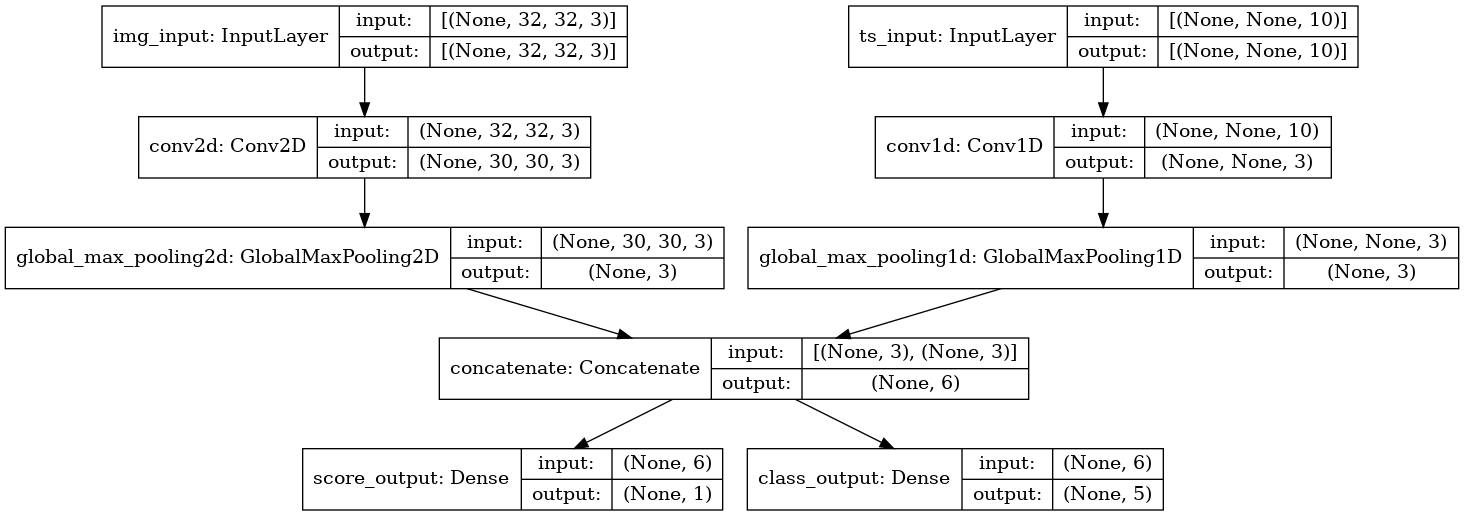

In [29]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

At compilation time, we can specify different losses to different outputs, by passing
the loss functions as a list:

In [30]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

If we only passed a single loss function to the model, the same loss function would be
applied to every output (which is not appropriate here).

Likewise for metrics:

In [31]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

Since we gave names to our output layers, we could also specify per-output losses and
metrics via a dict:

In [32]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

We recommend the use of explicit names and dicts if you have more than 2 outputs.

It's possible to give different weights to different output-specific losses (for
instance, one might wish to privilege the "score" loss in our example, by giving to 2x
the importance of the class loss), using the `loss_weights` argument:

In [33]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

You could also chose not to compute a loss for certain outputs, if these outputs meant
for prediction but not for training:

In [34]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

Passing data to a multi-input or multi-output model in fit works in a similar way as
specifying a loss function in compile: you can pass **lists of NumPy arrays** (with
1:1 mapping to the outputs that received a loss function) or **dicts mapping output
names to NumPy arrays**.

In [35]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

1/4 [======>.......................] - ETA: 7s - loss: 21.5185 - score_output_loss: 1.6206 - class_output_loss: 19.8979

4/4 [==============================] - 2s 12ms/step - loss: 19.3697 - score_output_loss: 1.3639 - class_output_loss: 18.0058


1/4 [======>.......................] - ETA: 1s - loss: 16.7058 - score_output_loss: 0.7971 - class_output_loss: 15.9087

4/4 [==============================] - 0s 6ms/step - loss: 17.6548 - score_output_loss: 0.7146 - class_output_loss: 16.9402


Here's the `Dataset` use case: similarly as what we did for NumPy arrays, the `Dataset`
should return a tuple of dicts.

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

1/2 [==============>...............] - ETA: 0s - loss: 17.4542 - score_output_loss: 0.5721 - class_output_loss: 16.8821

2/2 [==============================] - 0s 29ms/step - loss: 17.3215 - score_output_loss: 0.5076 - class_output_loss: 16.8139


## Using callbacks

Callbacks in Keras are objects that are called at different points during training (at
the start of an epoch, at the end of a batch, at the end of an epoch, etc.) and which
can be used to implement behaviors such as:

- Doing validation at different points during training (beyond the built-in per-epoch
validation)
- Checkpointing the model at regular intervals or when it exceeds a certain accuracy
threshold
- Changing the learning rate of the model when training seems to be plateauing
- Doing fine-tuning of the top layers when training seems to be plateauing
- Sending email or instant message notifications when training ends or where a certain
performance threshold is exceeded
- Etc.

Callbacks can be passed as a list to your call to `fit()`:

In [37]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20


  1/625 [..............................] - ETA: 3:47 - loss: 2.2701 - sparse_categorical_accuracy: 0.2031

 25/625 [>.............................] - ETA: 1s - loss: 1.8922 - sparse_categorical_accuracy: 0.4121  

 48/625 [=>............................] - ETA: 1s - loss: 1.6344 - sparse_categorical_accuracy: 0.5119

 72/625 [==>...........................] - ETA: 1s - loss: 1.4488 - sparse_categorical_accuracy: 0.5760

 97/625 [===>..........................] - ETA: 1s - loss: 1.3105 - sparse_categorical_accuracy: 0.6205

122/625 [====>.........................] - ETA: 1s - loss: 1.2079 - sparse_categorical_accuracy: 0.6523

146/625 [======>.......................] - ETA: 1s - loss: 1.1301 - sparse_categorical_accuracy: 0.6759

171/625 [=======>......................] - ETA: 0s - loss: 1.0643 - sparse_categorical_accuracy: 0.6957

197/625 [========>.....................] - ETA: 0s - loss: 1.0076 - sparse_categorical_accuracy: 0.7126

223/625 [=========>....................] - ETA: 0s - loss: 0.9601 - sparse_categorical_accuracy: 0.7266

248/625 [==========>...................] - ETA: 0s - loss: 0.9207 - sparse_categorical_accuracy: 0.7383

272/625 [============>.................] - ETA: 0s - loss: 0.8875 - sparse_categorical_accuracy: 0.7480

297/625 [=============>................] - ETA: 0s - loss: 0.8568 - sparse_categorical_accuracy: 0.7569

323/625 [==============>...............] - ETA: 0s - loss: 0.8283 - sparse_categorical_accuracy: 0.7651

349/625 [===============>..............] - ETA: 0s - loss: 0.8027 - sparse_categorical_accuracy: 0.7725

373/625 [================>.............] - ETA: 0s - loss: 0.7812 - sparse_categorical_accuracy: 0.7786

398/625 [==================>...........] - ETA: 0s - loss: 0.7607 - sparse_categorical_accuracy: 0.7844

423/625 [===================>..........] - ETA: 0s - loss: 0.7419 - sparse_categorical_accuracy: 0.7897

448/625 [====================>.........] - ETA: 0s - loss: 0.7246 - sparse_categorical_accuracy: 0.7946

473/625 [=====================>........] - ETA: 0s - loss: 0.7085 - sparse_categorical_accuracy: 0.7992

495/625 [======================>.......] - ETA: 0s - loss: 0.6953 - sparse_categorical_accuracy: 0.8029

521/625 [========================>.....] - ETA: 0s - loss: 0.6808 - sparse_categorical_accuracy: 0.8069

544/625 [=========================>....] - ETA: 0s - loss: 0.6688 - sparse_categorical_accuracy: 0.8103

567/625 [==========================>...] - ETA: 0s - loss: 0.6575 - sparse_categorical_accuracy: 0.8134

592/625 [===========================>..] - ETA: 0s - loss: 0.6460 - sparse_categorical_accuracy: 0.8166

617/625 [============================>.] - ETA: 0s - loss: 0.6351 - sparse_categorical_accuracy: 0.8197

625/625 [==============================] - 2s 3ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.8207 - val_loss: 0.2313 - val_sparse_categorical_accuracy: 0.9307


Epoch 2/20
  1/625 [..............................] - ETA: 1s - loss: 0.0831 - sparse_categorical_accuracy: 0.9844

 25/625 [>.............................] - ETA: 1s - loss: 0.1492 - sparse_categorical_accuracy: 0.9562

 49/625 [=>............................] - ETA: 1s - loss: 0.1661 - sparse_categorical_accuracy: 0.9495

 73/625 [==>...........................] - ETA: 1s - loss: 0.1737 - sparse_categorical_accuracy: 0.9470

 96/625 [===>..........................] - ETA: 1s - loss: 0.1779 - sparse_categorical_accuracy: 0.9457

118/625 [====>.........................] - ETA: 1s - loss: 0.1804 - sparse_categorical_accuracy: 0.9451

143/625 [=====>........................] - ETA: 1s - loss: 0.1820 - sparse_categorical_accuracy: 0.9447

167/625 [=======>......................] - ETA: 0s - loss: 0.1832 - sparse_categorical_accuracy: 0.9445

190/625 [========>.....................] - ETA: 0s - loss: 0.1840 - sparse_categorical_accuracy: 0.9444

214/625 [=========>....................] - ETA: 0s - loss: 0.1847 - sparse_categorical_accuracy: 0.9444

239/625 [==========>...................] - ETA: 0s - loss: 0.1850 - sparse_categorical_accuracy: 0.9444

264/625 [===========>..................] - ETA: 0s - loss: 0.1853 - sparse_categorical_accuracy: 0.9445

288/625 [============>.................] - ETA: 0s - loss: 0.1853 - sparse_categorical_accuracy: 0.9446

311/625 [=============>................] - ETA: 0s - loss: 0.1853 - sparse_categorical_accuracy: 0.9447

337/625 [===============>..............] - ETA: 0s - loss: 0.1854 - sparse_categorical_accuracy: 0.9447

363/625 [================>.............] - ETA: 0s - loss: 0.1855 - sparse_categorical_accuracy: 0.9448

389/625 [=================>............] - ETA: 0s - loss: 0.1855 - sparse_categorical_accuracy: 0.9448

413/625 [==================>...........] - ETA: 0s - loss: 0.1855 - sparse_categorical_accuracy: 0.9449

438/625 [====================>.........] - ETA: 0s - loss: 0.1853 - sparse_categorical_accuracy: 0.9450

462/625 [=====================>........] - ETA: 0s - loss: 0.1851 - sparse_categorical_accuracy: 0.9451

487/625 [======================>.......] - ETA: 0s - loss: 0.1848 - sparse_categorical_accuracy: 0.9452

511/625 [=======================>......] - ETA: 0s - loss: 0.1844 - sparse_categorical_accuracy: 0.9453

534/625 [========================>.....] - ETA: 0s - loss: 0.1841 - sparse_categorical_accuracy: 0.9454

558/625 [=========================>....] - ETA: 0s - loss: 0.1837 - sparse_categorical_accuracy: 0.9455

583/625 [==========================>...] - ETA: 0s - loss: 0.1834 - sparse_categorical_accuracy: 0.9457

608/625 [============================>.] - ETA: 0s - loss: 0.1830 - sparse_categorical_accuracy: 0.9458

625/625 [==============================] - 2s 3ms/step - loss: 0.1827 - sparse_categorical_accuracy: 0.9459 - val_loss: 0.1989 - val_sparse_categorical_accuracy: 0.9410


Epoch 3/20
  1/625 [..............................] - ETA: 1s - loss: 0.1063 - sparse_categorical_accuracy: 0.9688

 25/625 [>.............................] - ETA: 1s - loss: 0.1310 - sparse_categorical_accuracy: 0.9693

 50/625 [=>............................] - ETA: 1s - loss: 0.1281 - sparse_categorical_accuracy: 0.9665

 75/625 [==>...........................] - ETA: 1s - loss: 0.1298 - sparse_categorical_accuracy: 0.9646

 99/625 [===>..........................] - ETA: 1s - loss: 0.1321 - sparse_categorical_accuracy: 0.9635

124/625 [====>.........................] - ETA: 1s - loss: 0.1330 - sparse_categorical_accuracy: 0.9628

150/625 [======>.......................] - ETA: 0s - loss: 0.1333 - sparse_categorical_accuracy: 0.9624

175/625 [=======>......................] - ETA: 0s - loss: 0.1333 - sparse_categorical_accuracy: 0.9622

201/625 [========>.....................] - ETA: 0s - loss: 0.1331 - sparse_categorical_accuracy: 0.9621

225/625 [=========>....................] - ETA: 0s - loss: 0.1329 - sparse_categorical_accuracy: 0.9620

248/625 [==========>...................] - ETA: 0s - loss: 0.1326 - sparse_categorical_accuracy: 0.9620

272/625 [============>.................] - ETA: 0s - loss: 0.1322 - sparse_categorical_accuracy: 0.9621

298/625 [=============>................] - ETA: 0s - loss: 0.1319 - sparse_categorical_accuracy: 0.9621

324/625 [==============>...............] - ETA: 0s - loss: 0.1317 - sparse_categorical_accuracy: 0.9621

349/625 [===============>..............] - ETA: 0s - loss: 0.1315 - sparse_categorical_accuracy: 0.9621

373/625 [================>.............] - ETA: 0s - loss: 0.1315 - sparse_categorical_accuracy: 0.9620

398/625 [==================>...........] - ETA: 0s - loss: 0.1314 - sparse_categorical_accuracy: 0.9619

423/625 [===================>..........] - ETA: 0s - loss: 0.1313 - sparse_categorical_accuracy: 0.9619

448/625 [====================>.........] - ETA: 0s - loss: 0.1312 - sparse_categorical_accuracy: 0.9619

472/625 [=====================>........] - ETA: 0s - loss: 0.1310 - sparse_categorical_accuracy: 0.9619

495/625 [======================>.......] - ETA: 0s - loss: 0.1308 - sparse_categorical_accuracy: 0.9619

521/625 [========================>.....] - ETA: 0s - loss: 0.1306 - sparse_categorical_accuracy: 0.9619

546/625 [=========================>....] - ETA: 0s - loss: 0.1304 - sparse_categorical_accuracy: 0.9619

571/625 [==========================>...] - ETA: 0s - loss: 0.1302 - sparse_categorical_accuracy: 0.9619

596/625 [===========================>..] - ETA: 0s - loss: 0.1300 - sparse_categorical_accuracy: 0.9619

621/625 [============================>.] - ETA: 0s - loss: 0.1298 - sparse_categorical_accuracy: 0.9619

625/625 [==============================] - 2s 3ms/step - loss: 0.1298 - sparse_categorical_accuracy: 0.9619 - val_loss: 0.1561 - val_sparse_categorical_accuracy: 0.9529


Epoch 4/20
  1/625 [..............................] - ETA: 1s - loss: 0.2257 - sparse_categorical_accuracy: 0.9375

 25/625 [>.............................] - ETA: 1s - loss: 0.1025 - sparse_categorical_accuracy: 0.9698

 51/625 [=>............................] - ETA: 1s - loss: 0.0921 - sparse_categorical_accuracy: 0.9727

 77/625 [==>...........................] - ETA: 1s - loss: 0.0934 - sparse_categorical_accuracy: 0.9729

103/625 [===>..........................] - ETA: 1s - loss: 0.0948 - sparse_categorical_accuracy: 0.9725

127/625 [=====>........................] - ETA: 1s - loss: 0.0959 - sparse_categorical_accuracy: 0.9722

151/625 [======>.......................] - ETA: 0s - loss: 0.0965 - sparse_categorical_accuracy: 0.9721

177/625 [=======>......................] - ETA: 0s - loss: 0.0971 - sparse_categorical_accuracy: 0.9720

202/625 [========>.....................] - ETA: 0s - loss: 0.0972 - sparse_categorical_accuracy: 0.9719

225/625 [=========>....................] - ETA: 0s - loss: 0.0972 - sparse_categorical_accuracy: 0.9718

250/625 [===========>..................] - ETA: 0s - loss: 0.0973 - sparse_categorical_accuracy: 0.9717

276/625 [============>.................] - ETA: 0s - loss: 0.0973 - sparse_categorical_accuracy: 0.9717

301/625 [=============>................] - ETA: 0s - loss: 0.0972 - sparse_categorical_accuracy: 0.9716

326/625 [==============>...............] - ETA: 0s - loss: 0.0972 - sparse_categorical_accuracy: 0.9716

352/625 [===============>..............] - ETA: 0s - loss: 0.0972 - sparse_categorical_accuracy: 0.9716

379/625 [=================>............] - ETA: 0s - loss: 0.0973 - sparse_categorical_accuracy: 0.9716

403/625 [==================>...........] - ETA: 0s - loss: 0.0973 - sparse_categorical_accuracy: 0.9715

428/625 [===================>..........] - ETA: 0s - loss: 0.0973 - sparse_categorical_accuracy: 0.9715

452/625 [====================>.........] - ETA: 0s - loss: 0.0973 - sparse_categorical_accuracy: 0.9715

478/625 [=====================>........] - ETA: 0s - loss: 0.0974 - sparse_categorical_accuracy: 0.9714

504/625 [=======================>......] - ETA: 0s - loss: 0.0975 - sparse_categorical_accuracy: 0.9714

527/625 [========================>.....] - ETA: 0s - loss: 0.0975 - sparse_categorical_accuracy: 0.9714

551/625 [=========================>....] - ETA: 0s - loss: 0.0976 - sparse_categorical_accuracy: 0.9713

577/625 [==========================>...] - ETA: 0s - loss: 0.0976 - sparse_categorical_accuracy: 0.9713

604/625 [===========================>..] - ETA: 0s - loss: 0.0977 - sparse_categorical_accuracy: 0.9713

625/625 [==============================] - 2s 2ms/step - loss: 0.0977 - sparse_categorical_accuracy: 0.9713 - val_loss: 0.1434 - val_sparse_categorical_accuracy: 0.9576


Epoch 5/20
  1/625 [..............................] - ETA: 1s - loss: 0.0500 - sparse_categorical_accuracy: 0.9844

 26/625 [>.............................] - ETA: 1s - loss: 0.0708 - sparse_categorical_accuracy: 0.9794

 52/625 [=>............................] - ETA: 1s - loss: 0.0773 - sparse_categorical_accuracy: 0.9764

 76/625 [==>...........................] - ETA: 1s - loss: 0.0790 - sparse_categorical_accuracy: 0.9759

 99/625 [===>..........................] - ETA: 1s - loss: 0.0802 - sparse_categorical_accuracy: 0.9756

124/625 [====>.........................] - ETA: 1s - loss: 0.0808 - sparse_categorical_accuracy: 0.9754

148/625 [======>.......................] - ETA: 0s - loss: 0.0807 - sparse_categorical_accuracy: 0.9755

172/625 [=======>......................] - ETA: 0s - loss: 0.0806 - sparse_categorical_accuracy: 0.9756

194/625 [========>.....................] - ETA: 0s - loss: 0.0804 - sparse_categorical_accuracy: 0.9756

219/625 [=========>....................] - ETA: 0s - loss: 0.0801 - sparse_categorical_accuracy: 0.9757

243/625 [==========>...................] - ETA: 0s - loss: 0.0800 - sparse_categorical_accuracy: 0.9757

268/625 [===========>..................] - ETA: 0s - loss: 0.0798 - sparse_categorical_accuracy: 0.9757

293/625 [=============>................] - ETA: 0s - loss: 0.0796 - sparse_categorical_accuracy: 0.9758

319/625 [==============>...............] - ETA: 0s - loss: 0.0793 - sparse_categorical_accuracy: 0.9758

346/625 [===============>..............] - ETA: 0s - loss: 0.0790 - sparse_categorical_accuracy: 0.9759

371/625 [================>.............] - ETA: 0s - loss: 0.0790 - sparse_categorical_accuracy: 0.9759

395/625 [=================>............] - ETA: 0s - loss: 0.0790 - sparse_categorical_accuracy: 0.9759

419/625 [===================>..........] - ETA: 0s - loss: 0.0791 - sparse_categorical_accuracy: 0.9758

443/625 [====================>.........] - ETA: 0s - loss: 0.0792 - sparse_categorical_accuracy: 0.9758

469/625 [=====================>........] - ETA: 0s - loss: 0.0793 - sparse_categorical_accuracy: 0.9758

494/625 [======================>.......] - ETA: 0s - loss: 0.0794 - sparse_categorical_accuracy: 0.9757

519/625 [=======================>......] - ETA: 0s - loss: 0.0795 - sparse_categorical_accuracy: 0.9757

545/625 [=========================>....] - ETA: 0s - loss: 0.0796 - sparse_categorical_accuracy: 0.9756

572/625 [==========================>...] - ETA: 0s - loss: 0.0797 - sparse_categorical_accuracy: 0.9756

598/625 [===========================>..] - ETA: 0s - loss: 0.0798 - sparse_categorical_accuracy: 0.9756

621/625 [============================>.] - ETA: 0s - loss: 0.0799 - sparse_categorical_accuracy: 0.9755

625/625 [==============================] - 2s 3ms/step - loss: 0.0799 - sparse_categorical_accuracy: 0.9755 - val_loss: 0.1364 - val_sparse_categorical_accuracy: 0.9614


Epoch 6/20
  1/625 [..............................] - ETA: 1s - loss: 0.0507 - sparse_categorical_accuracy: 0.9844

 27/625 [>.............................] - ETA: 1s - loss: 0.0668 - sparse_categorical_accuracy: 0.9778

 52/625 [=>............................] - ETA: 1s - loss: 0.0632 - sparse_categorical_accuracy: 0.9795

 77/625 [==>...........................] - ETA: 1s - loss: 0.0634 - sparse_categorical_accuracy: 0.9801

103/625 [===>..........................] - ETA: 1s - loss: 0.0631 - sparse_categorical_accuracy: 0.9806

129/625 [=====>........................] - ETA: 0s - loss: 0.0631 - sparse_categorical_accuracy: 0.9809

154/625 [======>.......................] - ETA: 0s - loss: 0.0632 - sparse_categorical_accuracy: 0.9810

178/625 [=======>......................] - ETA: 0s - loss: 0.0633 - sparse_categorical_accuracy: 0.9810

203/625 [========>.....................] - ETA: 0s - loss: 0.0633 - sparse_categorical_accuracy: 0.9810

227/625 [=========>....................] - ETA: 0s - loss: 0.0633 - sparse_categorical_accuracy: 0.9810

250/625 [===========>..................] - ETA: 0s - loss: 0.0632 - sparse_categorical_accuracy: 0.9811

274/625 [============>.................] - ETA: 0s - loss: 0.0630 - sparse_categorical_accuracy: 0.9811

299/625 [=============>................] - ETA: 0s - loss: 0.0631 - sparse_categorical_accuracy: 0.9811

323/625 [==============>...............] - ETA: 0s - loss: 0.0632 - sparse_categorical_accuracy: 0.9811

347/625 [===============>..............] - ETA: 0s - loss: 0.0632 - sparse_categorical_accuracy: 0.9811

371/625 [================>.............] - ETA: 0s - loss: 0.0632 - sparse_categorical_accuracy: 0.9810

396/625 [==================>...........] - ETA: 0s - loss: 0.0633 - sparse_categorical_accuracy: 0.9810

422/625 [===================>..........] - ETA: 0s - loss: 0.0634 - sparse_categorical_accuracy: 0.9810

447/625 [====================>.........] - ETA: 0s - loss: 0.0636 - sparse_categorical_accuracy: 0.9809

472/625 [=====================>........] - ETA: 0s - loss: 0.0638 - sparse_categorical_accuracy: 0.9809

497/625 [======================>.......] - ETA: 0s - loss: 0.0639 - sparse_categorical_accuracy: 0.9808

523/625 [========================>.....] - ETA: 0s - loss: 0.0641 - sparse_categorical_accuracy: 0.9808

547/625 [=========================>....] - ETA: 0s - loss: 0.0643 - sparse_categorical_accuracy: 0.9807

570/625 [==========================>...] - ETA: 0s - loss: 0.0644 - sparse_categorical_accuracy: 0.9807

594/625 [===========================>..] - ETA: 0s - loss: 0.0646 - sparse_categorical_accuracy: 0.9806

619/625 [============================>.] - ETA: 0s - loss: 0.0647 - sparse_categorical_accuracy: 0.9806

625/625 [==============================] - 2s 3ms/step - loss: 0.0648 - sparse_categorical_accuracy: 0.9806 - val_loss: 0.1351 - val_sparse_categorical_accuracy: 0.9617


Epoch 00006: early stopping


### Many built-in callbacks are available

- `ModelCheckpoint`: Periodically save the model.
- `EarlyStopping`: Stop training when training is no longer improving the validation
metrics.
- `TensorBoard`: periodically write model logs that can be visualized in
[TensorBoard](https://www.tensorflow.org/tensorboard) (more details in the section
"Visualization").
- `CSVLogger`: streams loss and metrics data to a CSV file.
- etc.

See the [callbacks documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/) for the complete list.

### Writing your own callback

You can create a custom callback by extending the base class
`keras.callbacks.Callback`. A callback has access to its associated model through the
class property `self.model`.

Make sure to read the
[complete guide to writing custom callbacks](https://www.tensorflow.org/guide/keras/custom_callback/).

Here's a simple example saving a list of per-batch loss values during training:

In [38]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))


## Checkpointing models

When you're training model on relatively large datasets, it's crucial to save
checkpoints of your model at frequent intervals.

The easiest way to achieve this is with the `ModelCheckpoint` callback:

In [39]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2


  1/625 [..............................] - ETA: 3:39 - loss: 2.3585 - sparse_categorical_accuracy: 0.0781

 25/625 [>.............................] - ETA: 1s - loss: 1.9384 - sparse_categorical_accuracy: 0.3823  

 50/625 [=>............................] - ETA: 1s - loss: 1.6373 - sparse_categorical_accuracy: 0.5138

 76/625 [==>...........................] - ETA: 1s - loss: 1.4338 - sparse_categorical_accuracy: 0.5865

101/625 [===>..........................] - ETA: 1s - loss: 1.2970 - sparse_categorical_accuracy: 0.6312

126/625 [=====>........................] - ETA: 1s - loss: 1.1939 - sparse_categorical_accuracy: 0.6629

150/625 [======>.......................] - ETA: 0s - loss: 1.1163 - sparse_categorical_accuracy: 0.6859

175/625 [=======>......................] - ETA: 0s - loss: 1.0507 - sparse_categorical_accuracy: 0.7051

201/625 [========>.....................] - ETA: 0s - loss: 0.9940 - sparse_categorical_accuracy: 0.7214

226/625 [=========>....................] - ETA: 0s - loss: 0.9482 - sparse_categorical_accuracy: 0.7345

251/625 [===========>..................] - ETA: 0s - loss: 0.9086 - sparse_categorical_accuracy: 0.7457

277/625 [============>.................] - ETA: 0s - loss: 0.8727 - sparse_categorical_accuracy: 0.7558

302/625 [=============>................] - ETA: 0s - loss: 0.8421 - sparse_categorical_accuracy: 0.7644

327/625 [==============>...............] - ETA: 0s - loss: 0.8146 - sparse_categorical_accuracy: 0.7720

352/625 [===============>..............] - ETA: 0s - loss: 0.7899 - sparse_categorical_accuracy: 0.7789

377/625 [=================>............] - ETA: 0s - loss: 0.7675 - sparse_categorical_accuracy: 0.7851

402/625 [==================>...........] - ETA: 0s - loss: 0.7471 - sparse_categorical_accuracy: 0.7908

427/625 [===================>..........] - ETA: 0s - loss: 0.7284 - sparse_categorical_accuracy: 0.7960

451/625 [====================>.........] - ETA: 0s - loss: 0.7119 - sparse_categorical_accuracy: 0.8006

476/625 [=====================>........] - ETA: 0s - loss: 0.6959 - sparse_categorical_accuracy: 0.8051

501/625 [=======================>......] - ETA: 0s - loss: 0.6812 - sparse_categorical_accuracy: 0.8091

526/625 [========================>.....] - ETA: 0s - loss: 0.6675 - sparse_categorical_accuracy: 0.8129

551/625 [=========================>....] - ETA: 0s - loss: 0.6547 - sparse_categorical_accuracy: 0.8165

575/625 [==========================>...] - ETA: 0s - loss: 0.6432 - sparse_categorical_accuracy: 0.8196

601/625 [===========================>..] - ETA: 0s - loss: 0.6314 - sparse_categorical_accuracy: 0.8229

625/625 [==============================] - 2s 3ms/step - loss: 0.6208 - sparse_categorical_accuracy: 0.8258 - val_loss: 0.2241 - val_sparse_categorical_accuracy: 0.9326



Epoch 00001: val_loss improved from inf to 0.22410, saving model to mymodel_1


INFO:tensorflow:Assets written to: mymodel_1/assets


Epoch 2/2
  1/625 [..............................] - ETA: 2s - loss: 0.2515 - sparse_categorical_accuracy: 0.9531

 26/625 [>.............................] - ETA: 1s - loss: 0.2360 - sparse_categorical_accuracy: 0.9442

 50/625 [=>............................] - ETA: 1s - loss: 0.2243 - sparse_categorical_accuracy: 0.9427

 75/625 [==>...........................] - ETA: 1s - loss: 0.2171 - sparse_categorical_accuracy: 0.9424

 98/625 [===>..........................] - ETA: 1s - loss: 0.2124 - sparse_categorical_accuracy: 0.9423

121/625 [====>.........................] - ETA: 1s - loss: 0.2093 - sparse_categorical_accuracy: 0.9422

144/625 [=====>........................] - ETA: 1s - loss: 0.2066 - sparse_categorical_accuracy: 0.9424

168/625 [=======>......................] - ETA: 0s - loss: 0.2034 - sparse_categorical_accuracy: 0.9429

192/625 [========>.....................] - ETA: 0s - loss: 0.2007 - sparse_categorical_accuracy: 0.9434

215/625 [=========>....................] - ETA: 0s - loss: 0.1986 - sparse_categorical_accuracy: 0.9437

237/625 [==========>...................] - ETA: 0s - loss: 0.1968 - sparse_categorical_accuracy: 0.9440

260/625 [===========>..................] - ETA: 0s - loss: 0.1952 - sparse_categorical_accuracy: 0.9443

283/625 [============>.................] - ETA: 0s - loss: 0.1937 - sparse_categorical_accuracy: 0.9446

308/625 [=============>................] - ETA: 0s - loss: 0.1921 - sparse_categorical_accuracy: 0.9449

333/625 [==============>...............] - ETA: 0s - loss: 0.1908 - sparse_categorical_accuracy: 0.9451

359/625 [================>.............] - ETA: 0s - loss: 0.1896 - sparse_categorical_accuracy: 0.9454

385/625 [=================>............] - ETA: 0s - loss: 0.1885 - sparse_categorical_accuracy: 0.9457

409/625 [==================>...........] - ETA: 0s - loss: 0.1876 - sparse_categorical_accuracy: 0.9459

434/625 [===================>..........] - ETA: 0s - loss: 0.1868 - sparse_categorical_accuracy: 0.9460

460/625 [=====================>........] - ETA: 0s - loss: 0.1860 - sparse_categorical_accuracy: 0.9462

485/625 [======================>.......] - ETA: 0s - loss: 0.1854 - sparse_categorical_accuracy: 0.9463

509/625 [=======================>......] - ETA: 0s - loss: 0.1847 - sparse_categorical_accuracy: 0.9464

532/625 [========================>.....] - ETA: 0s - loss: 0.1841 - sparse_categorical_accuracy: 0.9466

557/625 [=========================>....] - ETA: 0s - loss: 0.1835 - sparse_categorical_accuracy: 0.9467

581/625 [==========================>...] - ETA: 0s - loss: 0.1830 - sparse_categorical_accuracy: 0.9468

605/625 [============================>.] - ETA: 0s - loss: 0.1825 - sparse_categorical_accuracy: 0.9469

625/625 [==============================] - 2s 3ms/step - loss: 0.1820 - sparse_categorical_accuracy: 0.9470 - val_loss: 0.1621 - val_sparse_categorical_accuracy: 0.9497



Epoch 00002: val_loss improved from 0.22410 to 0.16212, saving model to mymodel_2


INFO:tensorflow:Assets written to: mymodel_2/assets


The `ModelCheckpoint` callback can be used to implement fault-tolerance:
the ability to restart training from the last saved state of the model in case training
gets randomly interrupted. Here's a basic example:

In [40]:
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Creating a new model


   1/1563 [..............................] - ETA: 9:23 - loss: 2.3434 - sparse_categorical_accuracy: 0.1562

  25/1563 [..............................] - ETA: 3s - loss: 1.9716 - sparse_categorical_accuracy: 0.3518  

  49/1563 [..............................] - ETA: 3s - loss: 1.7207 - sparse_categorical_accuracy: 0.4686

  71/1563 [>.............................] - ETA: 3s - loss: 1.5595 - sparse_categorical_accuracy: 0.5315

  94/1563 [>.............................] - ETA: 3s - loss: 1.4324 - sparse_categorical_accuracy: 0.5773

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.96/assets


 101/1563 [>.............................] - ETA: 9s - loss: 1.4003 - sparse_categorical_accuracy: 0.5885

 125/1563 [=>............................] - ETA: 7s - loss: 1.3044 - sparse_categorical_accuracy: 0.6211

 148/1563 [=>............................] - ETA: 7s - loss: 1.2298 - sparse_categorical_accuracy: 0.6457

 170/1563 [==>...........................] - ETA: 6s - loss: 1.1698 - sparse_categorical_accuracy: 0.6648

 193/1563 [==>...........................] - ETA: 5s - loss: 1.1162 - sparse_categorical_accuracy: 0.6814

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.69/assets


 201/1563 [==>...........................] - ETA: 8s - loss: 1.0993 - sparse_categorical_accuracy: 0.6866

 222/1563 [===>..........................] - ETA: 8s - loss: 1.0585 - sparse_categorical_accuracy: 0.6990

 244/1563 [===>..........................] - ETA: 7s - loss: 1.0208 - sparse_categorical_accuracy: 0.7102

 266/1563 [====>.........................] - ETA: 7s - loss: 0.9873 - sparse_categorical_accuracy: 0.7201

 290/1563 [====>.........................] - ETA: 6s - loss: 0.9546 - sparse_categorical_accuracy: 0.7298

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.57/assets


 301/1563 [====>.........................] - ETA: 8s - loss: 0.9407 - sparse_categorical_accuracy: 0.7339

 325/1563 [=====>........................] - ETA: 7s - loss: 0.9127 - sparse_categorical_accuracy: 0.7420

 349/1563 [=====>........................] - ETA: 7s - loss: 0.8874 - sparse_categorical_accuracy: 0.7494

 372/1563 [======>.......................] - ETA: 6s - loss: 0.8651 - sparse_categorical_accuracy: 0.7559

 395/1563 [======>.......................] - ETA: 6s - loss: 0.8447 - sparse_categorical_accuracy: 0.7617

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.51/assets


 401/1563 [======>.......................] - ETA: 7s - loss: 0.8396 - sparse_categorical_accuracy: 0.7632

 424/1563 [=======>......................] - ETA: 7s - loss: 0.8213 - sparse_categorical_accuracy: 0.7684

 447/1563 [=======>......................] - ETA: 6s - loss: 0.8045 - sparse_categorical_accuracy: 0.7732

 470/1563 [========>.....................] - ETA: 6s - loss: 0.7889 - sparse_categorical_accuracy: 0.7776

 493/1563 [========>.....................] - ETA: 6s - loss: 0.7744 - sparse_categorical_accuracy: 0.7817

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.47/assets


 501/1563 [========>.....................] - ETA: 7s - loss: 0.7696 - sparse_categorical_accuracy: 0.7831

 526/1563 [=========>....................] - ETA: 6s - loss: 0.7552 - sparse_categorical_accuracy: 0.7871

 550/1563 [=========>....................] - ETA: 6s - loss: 0.7422 - sparse_categorical_accuracy: 0.7907

 574/1563 [==========>...................] - ETA: 6s - loss: 0.7300 - sparse_categorical_accuracy: 0.7941

 598/1563 [==========>...................] - ETA: 5s - loss: 0.7186 - sparse_categorical_accuracy: 0.7973

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.44/assets


 601/1563 [==========>...................] - ETA: 6s - loss: 0.7172 - sparse_categorical_accuracy: 0.7977

 626/1563 [===========>..................] - ETA: 6s - loss: 0.7060 - sparse_categorical_accuracy: 0.8008

 649/1563 [===========>..................] - ETA: 5s - loss: 0.6962 - sparse_categorical_accuracy: 0.8035

 672/1563 [===========>..................] - ETA: 5s - loss: 0.6870 - sparse_categorical_accuracy: 0.8060

 696/1563 [============>.................] - ETA: 5s - loss: 0.6778 - sparse_categorical_accuracy: 0.8086

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.42/assets


 701/1563 [============>.................] - ETA: 5s - loss: 0.6760 - sparse_categorical_accuracy: 0.8091

 724/1563 [============>.................] - ETA: 5s - loss: 0.6677 - sparse_categorical_accuracy: 0.8114

 747/1563 [=============>................] - ETA: 5s - loss: 0.6597 - sparse_categorical_accuracy: 0.8136

 771/1563 [=============>................] - ETA: 5s - loss: 0.6518 - sparse_categorical_accuracy: 0.8158

 794/1563 [==============>...............] - ETA: 4s - loss: 0.6445 - sparse_categorical_accuracy: 0.8178

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.40/assets


 801/1563 [==============>...............] - ETA: 5s - loss: 0.6423 - sparse_categorical_accuracy: 0.8184

 825/1563 [==============>...............] - ETA: 4s - loss: 0.6351 - sparse_categorical_accuracy: 0.8204

 848/1563 [===============>..............] - ETA: 4s - loss: 0.6284 - sparse_categorical_accuracy: 0.8222

 873/1563 [===============>..............] - ETA: 4s - loss: 0.6213 - sparse_categorical_accuracy: 0.8242

 898/1563 [================>.............] - ETA: 4s - loss: 0.6146 - sparse_categorical_accuracy: 0.8260

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.38/assets


 901/1563 [================>.............] - ETA: 4s - loss: 0.6138 - sparse_categorical_accuracy: 0.8262

 925/1563 [================>.............] - ETA: 4s - loss: 0.6076 - sparse_categorical_accuracy: 0.8279

 948/1563 [=================>............] - ETA: 3s - loss: 0.6018 - sparse_categorical_accuracy: 0.8295

 970/1563 [=================>............] - ETA: 3s - loss: 0.5966 - sparse_categorical_accuracy: 0.8309

 995/1563 [==================>...........] - ETA: 3s - loss: 0.5907 - sparse_categorical_accuracy: 0.8326

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.36/assets


1001/1563 [==================>...........] - ETA: 3s - loss: 0.5894 - sparse_categorical_accuracy: 0.8329

1025/1563 [==================>...........] - ETA: 3s - loss: 0.5840 - sparse_categorical_accuracy: 0.8344

1048/1563 [===================>..........] - ETA: 3s - loss: 0.5790 - sparse_categorical_accuracy: 0.8358

1072/1563 [===================>..........] - ETA: 3s - loss: 0.5740 - sparse_categorical_accuracy: 0.8372

1095/1563 [====================>.........] - ETA: 2s - loss: 0.5693 - sparse_categorical_accuracy: 0.8385

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.35/assets


1101/1563 [====================>.........] - ETA: 3s - loss: 0.5681 - sparse_categorical_accuracy: 0.8388

1124/1563 [====================>.........] - ETA: 2s - loss: 0.5636 - sparse_categorical_accuracy: 0.8400

1148/1563 [=====================>........] - ETA: 2s - loss: 0.5591 - sparse_categorical_accuracy: 0.8413

1172/1563 [=====================>........] - ETA: 2s - loss: 0.5546 - sparse_categorical_accuracy: 0.8425

1196/1563 [=====================>........] - ETA: 2s - loss: 0.5503 - sparse_categorical_accuracy: 0.8437

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.34/assets


1201/1563 [======================>.......] - ETA: 2s - loss: 0.5494 - sparse_categorical_accuracy: 0.8439

1224/1563 [======================>.......] - ETA: 2s - loss: 0.5454 - sparse_categorical_accuracy: 0.8451

1248/1563 [======================>.......] - ETA: 2s - loss: 0.5413 - sparse_categorical_accuracy: 0.8462

1272/1563 [=======================>......] - ETA: 1s - loss: 0.5374 - sparse_categorical_accuracy: 0.8473

1297/1563 [=======================>......] - ETA: 1s - loss: 0.5334 - sparse_categorical_accuracy: 0.8484

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.33/assets


1301/1563 [=======================>......] - ETA: 1s - loss: 0.5328 - sparse_categorical_accuracy: 0.8486

1324/1563 [========================>.....] - ETA: 1s - loss: 0.5292 - sparse_categorical_accuracy: 0.8495

1347/1563 [========================>.....] - ETA: 1s - loss: 0.5257 - sparse_categorical_accuracy: 0.8505

1368/1563 [=========================>....] - ETA: 1s - loss: 0.5226 - sparse_categorical_accuracy: 0.8514

1391/1563 [=========================>....] - ETA: 1s - loss: 0.5193 - sparse_categorical_accuracy: 0.8523

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.32/assets


1401/1563 [=========================>....] - ETA: 1s - loss: 0.5179 - sparse_categorical_accuracy: 0.8527

1425/1563 [==========================>...] - ETA: 0s - loss: 0.5146 - sparse_categorical_accuracy: 0.8536

1449/1563 [==========================>...] - ETA: 0s - loss: 0.5113 - sparse_categorical_accuracy: 0.8545

1472/1563 [===========================>..] - ETA: 0s - loss: 0.5082 - sparse_categorical_accuracy: 0.8554

1497/1563 [===========================>..] - ETA: 0s - loss: 0.5050 - sparse_categorical_accuracy: 0.8563

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.31/assets


1501/1563 [===========================>..] - ETA: 0s - loss: 0.5044 - sparse_categorical_accuracy: 0.8564

1526/1563 [============================>.] - ETA: 0s - loss: 0.5013 - sparse_categorical_accuracy: 0.8573

1548/1563 [============================>.] - ETA: 0s - loss: 0.4985 - sparse_categorical_accuracy: 0.8581

1563/1563 [==============================] - 11s 6ms/step - loss: 0.4966 - sparse_categorical_accuracy: 0.8586


You call also write your own callback for saving and restoring models.

For a complete guide on serialization and saving, see the
[guide to saving and serializing Models](https://www.tensorflow.org/guide/keras/save_and_serialize/).

## Using learning rate schedules

A common pattern when training deep learning models is to gradually reduce the learning
as training progresses. This is generally known as "learning rate decay".

The learning decay schedule could be static (fixed in advance, as a function of the
current epoch or the current batch index), or dynamic (responding to the current
behavior of the model, in particular the validation loss).

### Passing a schedule to an optimizer

You can easily use a static learning rate decay schedule by passing a schedule object
as the `learning_rate` argument in your optimizer:

In [41]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

Several built-in schedules are available: `ExponentialDecay`, `PiecewiseConstantDecay`,
`PolynomialDecay`, and `InverseTimeDecay`.

### Using callbacks to implement a dynamic learning rate schedule

A dynamic learning rate schedule (for instance, decreasing the learning rate when the
validation loss is no longer improving) cannot be achieved with these schedule objects
since the optimizer does not have access to validation metrics.

However, callbacks do have access to all metrics, including validation metrics! You can
thus achieve this pattern by using a callback that modifies the current learning rate
on the optimizer. In fact, this is even built-in as the `ReduceLROnPlateau` callback.

## Visualizing loss and metrics during training

The best way to keep an eye on your model during training is to use
[TensorBoard](https://www.tensorflow.org/tensorboard), a browser-based application
that you can run locally that provides you with:

- Live plots of the loss and metrics for training and evaluation
- (optionally) Visualizations of the histograms of your layer activations
- (optionally) 3D visualizations of the embedding spaces learned by your `Embedding`
layers

If you have installed TensorFlow with pip, you should be able to launch TensorBoard
from the command line:

```
tensorboard --logdir=/full_path_to_your_logs
```

### Using the TensorBoard callback

The easiest way to use TensorBoard with a Keras model and the fit method is the
`TensorBoard` callback.

In the simplest case, just specify where you want the callback to write logs, and
you're good to go:

In [42]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

For more information, see the
[documentation for the `TensorBoard` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/tensorboard/).